In [1]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import GRU, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from google.colab import drive
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import os
from tqdm import tqdm
import pickle

In [2]:
# Carregar o drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#200 trials n_layers': 1, 'n_units_lstm1': 115, 'dropout_rate_lstm1': 0.0009899544402645344, 'activation_lstm1': 'relu', 'n_units_dense': 52, 'activation_dense': 'relu', 'optimizer': 'adam', 'lookback': 7, 'batch_size': 64, 'learning_rate': 0.007770164265048791

##50 trials
n_layers': 1, 'n_units_lstm1': 205, 'dropout_rate_lstm1': 0.16216244641644745, 'activation_lstm1': 'tanh', 'n_units_dense': 55, 'activation_dense': 'tanh', 'optimizer': 'sgd', 'lookback': 3, 'batch_size': 32, 'learning_rate': 0.004489228753135746}


In [ ]:
'''# Definição de hiperparametros *Melhores apos 200 trials do optuna

n_layers = 1
n_units_lstm1 = 115
dropout_rate_lstm1 = 0.0009899544402645344
activation_lstm1 = 'relu'
n_units_dense = 52
activation_dense = 'relu'
optimizer = 'adam'
lookback = 7
batch_size = 64
learning_rate = 0.007770164265048791'''

In [3]:
#Hiperparametros
n_layers = 1
n_units_lstm1 = 205
dropout_rate_lstm1 = 0.16216244641644745
activation_lstm1 = 'tanh'
n_units_dense = 55
activation_dense = 'tanh'
optimizer = 'sgd'
lookback = 3
batch_size = 32
learning_rate = 0.004489228753135746


In [4]:
# Carregar o arquivo CSV sem índice e com a coluna 'Date' no formato datetime
df = pd.read_csv(
    "/content/drive/MyDrive/Mestrado/df_indice_brasil_endogenous_exogenous_red1.csv",
    sep=',',
    parse_dates=['Date'],  # Converte a coluna 'Date' para datetime
    index_col=None         # Não define uma coluna de índice
)

# Visualizar as primeiras linhas para confirmar o carregamento
df.head()

,Unnamed: 0,Date,Close,High,Low,Volume,USD
0,0,2013-01-02,62550.10,62887.0,60990.0,3739800.0,2.0456
1,1,2013-01-03,63312.46,63473.0,62341.0,3355800.0,2.0456
2,2,2013-01-04,62523.06,63314.0,62415.0,6233800.0,2.0487
3,3,2013-01-07,61932.54,62699.0,61639.0,3985800.0,2.0324
4,4,2013-01-08,61127.84,62265.0,61081.0,3840600.0,2.0264


In [5]:
#carregar base de dados
# Selecionar apenas as colunas desejadas
df = df[['Date', 'Close', 'High', 'Low', 'Volume', 'USD']]

# Verificar as informações do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2724 entries, 0 to 2723
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2724 non-null   datetime64[ns]
 1   Close   2724 non-null   float64       
 2   High    2724 non-null   float64       
 3   Low     2724 non-null   float64       
 4   Volume  2724 non-null   float64       
 5   USD     2724 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 127.8 KB


In [6]:
#separação dos dados em treino, validação e teste
train_size = int(len(df['Close']) * 0.75)
val_size = int(len(df['Close']) * 0.85)

df_train = df.iloc[:train_size].copy()
df_test = df.iloc[val_size:].copy()

In [7]:
# Normalização das colunas 'Close'
train_mean = df_train[['Close']].mean().values
train_std = df_train[['Close']].std().values

train_not_norm = df_train[['Close']].to_numpy()
test_not_norm = df_test[['Close']].to_numpy()

train_norm = (train_not_norm - train_mean) / train_std
test_norm = (test_not_norm - train_mean) / train_std

# Preparação dos dados de treino e valide com exógena 'High'
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=train_norm[:-1],
    targets=train_norm[lookback:, 0],
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

validation_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=test_norm[:-1],
    targets=test_norm[lookback:, 0],
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

In [8]:
# Preparação dos dados de treino

# Normalização dos dados de treino
train_mean = df_train['Close'].mean()
train_std = df_train['Close'].std()

train_not_norm = df_train['Close'].to_numpy()

train_norm = (train_not_norm - train_mean) / train_std

# Preparação dos dados de treino
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=train_norm[:-1],
    targets=train_norm[lookback:],
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

# Preparação dos dados de teste

test_not_norm = df_test['Close'].to_numpy()

# Normalização dos dados de teste usando a média e desvio padrão dos dados de treino
test_norm = (test_not_norm - train_mean) / train_std

# Preparação dos dados de teste
validation_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=test_norm[:-1],
    targets=test_norm[lookback:],
    sequence_length=lookback,
    shuffle=False,
    batch_size=batch_size
)

In [11]:
def save_model(model, optimizer, metrics, seed, filename='bestresults'):
    # Salvar o modelo e suas métricas
    model.save(filename + '.keras')
    with open(filename + '.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')
        f.write(f'Seed: {seed}\n')

    # Salvar o otimizador
    with open(filename + '_optimizer.pkl', 'wb') as f:
        pickle.dump(optimizer.get_config(), f)

In [14]:
# Criação de diretório e salvar modelos e history
patience = 10
runs=100
results_dir = f'/content/drive/MyDrive/GRU/GRU_p{patience}_bestresults_Close'

best_model = None
best_history = None
best_mape = float('inf')
all_metrics = []
all_history = []

In [15]:
# Lista para armazenar as métricas de cada run
all_metrics = []

# Loop para executar os runs
for run_num in tqdm(range(0, runs)):

    # Definir e armazenar a seed para cada trial
    seed = run_num
    random.seed(seed)
    tf.random.set_seed(seed)

    print("\nStarting Run", run_num, "with seed", seed)

    # Inicializar o modelo GRU
    model = Sequential()
    model.add(GRU(n_units_lstm1, activation=activation_lstm1, input_shape=(lookback, 1)))
    model.add(Dropout(dropout_rate_lstm1))
    model.add(Dense(n_units_dense, activation=activation_dense))
    model.add(Dense(1))

    # Cria uma instância do otimizador Adam com a taxa de aprendizado desejada
    opt = Adam(learning_rate=learning_rate)

    # Compila o modelo
    model.compile(optimizer=opt, loss='mae')

    # Definir os callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Treinar o modelo
    history = model.fit(train_dataset, epochs=200, validation_data=validation_dataset, callbacks=[early_stopping], verbose=1)

    # Fazer previsões
    val_predict = model.predict(validation_dataset)
    predict = (val_predict * train_std) + train_mean

    # Ajustar os dados de entrada e previstos para terem o mesmo tamanho
    y_real = test_not_norm[lookback:]
    y_predict = predict.squeeze()

    # Calcular métricas
    mae = mean_absolute_error(y_real, y_predict)
    mse = mean_squared_error(y_real, y_predict)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_real - y_predict) / y_real)) * 100
    r2 = r2_score(y_real, y_predict)
    # Imprimir as métricas
    print(f"Run {run_num}, Seed {seed}")
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}, R2: {r2}")

    # Armazenar as métricas para cada run
    run_metrics = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Run': run_num}
    all_metrics.append(run_metrics)
    all_history.append(history)

    if mape < best_mape:
        best_mape = mape
        best_model = model
        best_history = history  # Atualiza o histórico do melhor modelo

        save_model(best_model, opt, run_metrics, seed, os.path.join(results_dir, 'best_model'))

        # Atualiza best_history apenas se um novo melhor modelo for encontrado
        best_history = history

    print(run_metrics)


  0%|          | 0/100 [00:00<?, ?it/s]


Starting Run 0 with seed 0
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.2399 - val_loss: 0.2190
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0621 - val_loss: 0.0636
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0737 - val_loss: 0.2055
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1358 - val_loss: 0.0689
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1016 - val_loss: 0.1307
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0570 - val_loss: 0.1442
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0546 - val_loss: 0.0904
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1591 - val_loss: 0.2066
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0700 - val_loss: 0.0606
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0620 - val_loss: 0.0801
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1271 - val_loss: 0.1046
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

  1%|          | 1/100 [00:27<46:07, 27.96s/it]

Run 0, Seed 0
MAE: 1346.376405480296, MSE: 2861527.042736529, RMSE: 1691.6048719297687, MAPE: 1.2082689828307054, R2: 0.950944123212331
{'MAE': 1346.376405480296, 'MSE': 2861527.042736529, 'RMSE': 1691.6048719297687, 'MAPE': 1.2082689828307054, 'R2': 0.950944123212331, 'Run': 0}

Starting Run 1 with seed 1
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2249 - val_loss: 0.1861
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1244 - val_loss: 0.3508
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3900 - val_loss: 0.0627
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0553 - val_loss: 0.0591
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1226 - val_loss: 0.1071
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1416 - val_loss: 0.1022
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1612 - val_loss: 0.1779
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1666 - val_loss: 0.0895
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1269 - val_loss: 0.0947
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1798 - val_loss: 0.0790
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2276 - val_loss: 0.0792
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1

  2%|▏         | 2/100 [00:47<38:02, 23.30s/it]

Run 1, Seed 1
MAE: 1314.3376246921187, MSE: 2702477.866216556, RMSE: 1643.9214902836925, MAPE: 1.1652551181586241, R2: 0.9536707431918098
{'MAE': 1314.3376246921187, 'MSE': 2702477.866216556, 'RMSE': 1643.9214902836925, 'MAPE': 1.1652551181586241, 'R2': 0.9536707431918098, 'Run': 1}

Starting Run 2 with seed 2
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.2153 - val_loss: 0.2915
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0733 - val_loss: 0.0538
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0691 - val_loss: 0.1737
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0642 - val_loss: 0.2366
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0785 - val_loss: 0.0582
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1738 - val_loss: 0.0817
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1130 - val_loss: 0.1801
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0963 - val_loss: 0.0731
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1056 - val_loss: 0.1309
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0653 - val_loss: 0.0647
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0843 - val_loss: 0.2196
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1

  3%|▎         | 3/100 [01:06<33:48, 20.92s/it]

Run 2, Seed 2
MAE: 1196.1781072967983, MSE: 2193273.494505569, RMSE: 1480.9704569995881, MAPE: 1.0728472915667893, R2: 0.9624001616265586
{'MAE': 1196.1781072967983, 'MSE': 2193273.494505569, 'RMSE': 1480.9704569995881, 'MAPE': 1.0728472915667893, 'R2': 0.9624001616265586, 'Run': 2}

Starting Run 3 with seed 3
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2331 - val_loss: 0.2453
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0929 - val_loss: 0.2634
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0954 - val_loss: 0.1696
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0988 - val_loss: 0.1530
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0879 - val_loss: 0.0919
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1461 - val_loss: 0.1968
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1436 - val_loss: 0.0878
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0863 - val_loss: 0.1491
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1056 - val_loss: 0.2011
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1656 - val_loss: 0.0924
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1413 - val_loss: 0.0777
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1

  4%|▍         | 4/100 [01:44<44:17, 27.68s/it]

Run 3, Seed 3
MAE: 1575.1907596982765, MSE: 4959180.195541278, RMSE: 2226.921685991961, MAPE: 1.3708407448740971, R2: 0.9149835283724347
{'MAE': 1575.1907596982765, 'MSE': 4959180.195541278, 'RMSE': 2226.921685991961, 'MAPE': 1.3708407448740971, 'R2': 0.9149835283724347, 'Run': 3}

Starting Run 4 with seed 4
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.1986 - val_loss: 0.0900
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0654 - val_loss: 0.0848
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0759 - val_loss: 0.1947
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0970 - val_loss: 0.0668
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0710 - val_loss: 0.1072
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1027 - val_loss: 0.2072
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0544 - val_loss: 0.1664
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0748 - val_loss: 0.1550
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0538 - val_loss: 0.1070
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0683 - val_loss: 0.0911
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1203 - val_loss: 0.1733
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0

  5%|▌         | 5/100 [02:06<40:51, 25.80s/it]

Run 4, Seed 4
MAE: 1485.648428263547, MSE: 3432725.1613777354, RMSE: 1852.7614960857038, MAPE: 1.340367130380744, R2: 0.9411519304037617
{'MAE': 1485.648428263547, 'MSE': 3432725.1613777354, 'RMSE': 1852.7614960857038, 'MAPE': 1.340367130380744, 'R2': 0.9411519304037617, 'Run': 4}

Starting Run 5 with seed 5
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1318 - val_loss: 0.0631
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0772 - val_loss: 0.0631
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0827 - val_loss: 0.3226
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1634 - val_loss: 0.1156
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0789 - val_loss: 0.0560
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1265 - val_loss: 0.0700
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0984 - val_loss: 0.2008
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0816 - val_loss: 0.0628
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1050 - val_loss: 0.1187
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1226 - val_loss: 0.1178
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0940 - val_loss: 0.1776
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

  6%|▌         | 6/100 [02:27<37:46, 24.11s/it]

Run 5, Seed 5
MAE: 1245.2766833435965, MSE: 2401098.3329219734, RMSE: 1549.5477833619632, MAPE: 1.1120511522770893, R2: 0.958837368224815
{'MAE': 1245.2766833435965, 'MSE': 2401098.3329219734, 'RMSE': 1549.5477833619632, 'MAPE': 1.1120511522770893, 'R2': 0.958837368224815, 'Run': 5}

Starting Run 6 with seed 6
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.2371 - val_loss: 0.2287
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0657 - val_loss: 0.0552
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0706 - val_loss: 0.1841
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0652 - val_loss: 0.0591
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0755 - val_loss: 0.1455
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0591 - val_loss: 0.0724
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1103 - val_loss: 0.0733
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1202 - val_loss: 0.1410
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0903 - val_loss: 0.1707
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0836 - val_loss: 0.1211
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0927 - val_loss: 0.1102
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1

  7%|▋         | 7/100 [02:45<34:12, 22.07s/it]

Run 6, Seed 6
MAE: 1227.8610822044338, MSE: 2254471.2928607524, RMSE: 1501.4896912269337, MAPE: 1.1036257918347252, R2: 0.9613510323990684
{'MAE': 1227.8610822044338, 'MSE': 2254471.2928607524, 'RMSE': 1501.4896912269337, 'MAPE': 1.1036257918347252, 'R2': 0.9613510323990684, 'Run': 6}

Starting Run 7 with seed 7
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1967 - val_loss: 0.2756
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0820 - val_loss: 0.1618
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1439 - val_loss: 0.0573
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0976 - val_loss: 0.1030
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1034 - val_loss: 0.0674
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0748 - val_loss: 0.0687
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0714 - val_loss: 0.2106
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0602 - val_loss: 0.1320
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1081 - val_loss: 0.1983
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0639 - val_loss: 0.0724
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0727 - val_loss: 0.0818
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1

  8%|▊         | 8/100 [03:04<32:22, 21.12s/it]

Run 7, Seed 7
MAE: 1273.3107974137938, MSE: 2486319.1247178814, RMSE: 1576.8066224866895, MAPE: 1.129850176500241, R2: 0.957376406787215
{'MAE': 1273.3107974137938, 'MSE': 2486319.1247178814, 'RMSE': 1576.8066224866895, 'MAPE': 1.129850176500241, 'R2': 0.957376406787215, 'Run': 7}

Starting Run 8 with seed 8
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1840 - val_loss: 0.0858
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1013 - val_loss: 0.0845
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0837 - val_loss: 0.2671
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0863 - val_loss: 0.1265
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1135 - val_loss: 0.2315
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0680 - val_loss: 0.0941
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0626 - val_loss: 0.0789
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0829 - val_loss: 0.0717
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1187 - val_loss: 0.0954
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1028 - val_loss: 0.1762
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0661 - val_loss: 0.0969
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0

  9%|▉         | 9/100 [03:29<34:06, 22.49s/it]

Run 8, Seed 8
MAE: 1594.112841748769, MSE: 4198574.193381482, RMSE: 2049.0422624683665, MAPE: 1.4176082255141602, R2: 0.9280227880993775
{'MAE': 1594.112841748769, 'MSE': 4198574.193381482, 'RMSE': 2049.0422624683665, 'MAPE': 1.4176082255141602, 'R2': 0.9280227880993775, 'Run': 8}

Starting Run 9 with seed 9
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.2265 - val_loss: 0.2021
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1023 - val_loss: 0.1192
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1045 - val_loss: 0.0959
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0668 - val_loss: 0.1505
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0586 - val_loss: 0.0724
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0969 - val_loss: 0.0691
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0870 - val_loss: 0.1539
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0652 - val_loss: 0.0636
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0641 - val_loss: 0.0795
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0939 - val_loss: 0.1045
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0775 - val_loss: 0.1188
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 10%|█         | 10/100 [04:00<37:41, 25.12s/it]

Run 9, Seed 9
MAE: 1414.653575277094, MSE: 3145607.7374935374, RMSE: 1773.5861235061402, MAPE: 1.2689068088297837, R2: 0.9460740565131087
{'MAE': 1414.653575277094, 'MSE': 3145607.7374935374, 'RMSE': 1773.5861235061402, 'MAPE': 1.2689068088297837, 'R2': 0.9460740565131087, 'Run': 9}

Starting Run 10 with seed 10
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1376 - val_loss: 0.1117
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0858 - val_loss: 0.1053
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0928 - val_loss: 0.0562
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0910 - val_loss: 0.1678
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1340 - val_loss: 0.2581
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1186 - val_loss: 0.1301
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0751 - val_loss: 0.1909
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1135 - val_loss: 0.1337
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1324 - val_loss: 0.0760
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1199 - val_loss: 0.0855
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1244 - val_loss: 0.0706
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 11%|█         | 11/100 [04:20<34:51, 23.50s/it]

Run 10, Seed 10
MAE: 1249.4942179802958, MSE: 2445087.890756405, RMSE: 1563.677681223469, MAPE: 1.1272866807696469, R2: 0.9580832441865511
{'MAE': 1249.4942179802958, 'MSE': 2445087.890756405, 'RMSE': 1563.677681223469, 'MAPE': 1.1272866807696469, 'R2': 0.9580832441865511, 'Run': 10}

Starting Run 11 with seed 11
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.1366 - val_loss: 0.1921
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1121 - val_loss: 0.1053
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2054 - val_loss: 0.0855
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1267 - val_loss: 0.2141
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0840 - val_loss: 0.0627
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0926 - val_loss: 0.0739
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1327 - val_loss: 0.0808
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0959 - val_loss: 0.1608
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0761 - val_loss: 0.0675
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0684 - val_loss: 0.0917
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1125 - val_loss: 0.1435
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1

 12%|█▏        | 12/100 [04:44<34:41, 23.65s/it]

Run 11, Seed 11
MAE: 1393.4961537869458, MSE: 2985451.0200446867, RMSE: 1727.8457743805398, MAPE: 1.2475801659024899, R2: 0.9488196633448984
{'MAE': 1393.4961537869458, 'MSE': 2985451.0200446867, 'RMSE': 1727.8457743805398, 'MAPE': 1.2475801659024899, 'R2': 0.9488196633448984, 'Run': 11}

Starting Run 12 with seed 12
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2097 - val_loss: 0.0931
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1584 - val_loss: 0.4106
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1532 - val_loss: 0.0725
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0625 - val_loss: 0.0910
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0514 - val_loss: 0.1184
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0680 - val_loss: 0.0828
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1374 - val_loss: 0.0920
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1058 - val_loss: 0.1854
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0759 - val_loss: 0.1276
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1023 - val_loss: 0.1632
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1331 - val_loss: 0.0938
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1

 13%|█▎        | 13/100 [05:04<32:23, 22.34s/it]

Run 12, Seed 12
MAE: 1612.7001639470445, MSE: 3993637.0585816586, RMSE: 1998.4086315320144, MAPE: 1.4589872884664215, R2: 0.9315360768727535
{'MAE': 1612.7001639470445, 'MSE': 3993637.0585816586, 'RMSE': 1998.4086315320144, 'MAPE': 1.4589872884664215, 'R2': 0.9315360768727535, 'Run': 12}

Starting Run 13 with seed 13
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.2141 - val_loss: 0.0621
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0713 - val_loss: 0.1396
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0947 - val_loss: 0.2444
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1058 - val_loss: 0.1554
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1566 - val_loss: 0.0784
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1469 - val_loss: 0.1952
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0462 - val_loss: 0.0709
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0764 - val_loss: 0.0697
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0940 - val_loss: 0.0769
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1335 - val_loss: 0.0774
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1232 - val_loss: 0.1679
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█▍        | 14/100 [05:20<29:34, 20.63s/it]

Run 13, Seed 13
MAE: 1379.9347075123158, MSE: 3003252.3472239794, RMSE: 1732.9894250179311, MAPE: 1.2163974156168016, R2: 0.9485144907221266
{'MAE': 1379.9347075123158, 'MSE': 3003252.3472239794, 'RMSE': 1732.9894250179311, 'MAPE': 1.2163974156168016, 'R2': 0.9485144907221266, 'Run': 13}

Starting Run 14 with seed 14
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.2400 - val_loss: 0.1376
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1024 - val_loss: 0.3134
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0913 - val_loss: 0.0979
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0556 - val_loss: 0.0711
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1067 - val_loss: 0.0681
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0920 - val_loss: 0.0797
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1158 - val_loss: 0.2283
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0603 - val_loss: 0.0895
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0626 - val_loss: 0.0986
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0958 - val_loss: 0.0881
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1101 - val_loss: 0.1112
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0

 15%|█▌        | 15/100 [05:43<30:17, 21.38s/it]

Run 14, Seed 14
MAE: 1513.6620166256162, MSE: 3746542.658655136, RMSE: 1935.5987855583955, MAPE: 1.3204479441998604, R2: 0.9357720782303107
{'MAE': 1513.6620166256162, 'MSE': 3746542.658655136, 'RMSE': 1935.5987855583955, 'MAPE': 1.3204479441998604, 'R2': 0.9357720782303107, 'Run': 14}

Starting Run 15 with seed 15
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2047 - val_loss: 0.0902
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0934 - val_loss: 0.0727
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0970 - val_loss: 0.2531
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1118 - val_loss: 0.1434
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0596 - val_loss: 0.0645
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0890 - val_loss: 0.0642
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1077 - val_loss: 0.1110
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0640 - val_loss: 0.0598
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1093 - val_loss: 0.0753
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1579 - val_loss: 0.0868
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1099 - val_loss: 0.1421
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1

 16%|█▌        | 16/100 [06:11<32:27, 23.19s/it]

Run 15, Seed 15
MAE: 1328.7843411330055, MSE: 2794985.65099606, RMSE: 1671.8210583061993, MAPE: 1.1805383155898774, R2: 0.9520848590033089
{'MAE': 1328.7843411330055, 'MSE': 2794985.65099606, 'RMSE': 1671.8210583061993, 'MAPE': 1.1805383155898774, 'R2': 0.9520848590033089, 'Run': 15}

Starting Run 16 with seed 16
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2293 - val_loss: 0.2102
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0545 - val_loss: 0.0807
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1040 - val_loss: 0.0771
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1729 - val_loss: 0.2550
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1012 - val_loss: 0.1222
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0458 - val_loss: 0.0832
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0830 - val_loss: 0.0858
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0842 - val_loss: 0.0629
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1207 - val_loss: 0.1092
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0998 - val_loss: 0.1393
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0743 - val_loss: 0.0914
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 17%|█▋        | 17/100 [06:39<34:23, 24.86s/it]

Run 16, Seed 16
MAE: 1397.9809390394093, MSE: 3255821.183886204, RMSE: 1804.3894213517779, MAPE: 1.2231936899029694, R2: 0.9441846397206634
{'MAE': 1397.9809390394093, 'MSE': 3255821.183886204, 'RMSE': 1804.3894213517779, 'MAPE': 1.2231936899029694, 'R2': 0.9441846397206634, 'Run': 16}

Starting Run 17 with seed 17
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1747 - val_loss: 0.3493
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1566 - val_loss: 0.0766
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0678 - val_loss: 0.0683
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1169 - val_loss: 0.0717
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1222 - val_loss: 0.1924
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1279 - val_loss: 0.0923
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1139 - val_loss: 0.0952
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1307 - val_loss: 0.1566
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1761 - val_loss: 0.0763
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1728 - val_loss: 0.0816
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2306 - val_loss: 0.1046
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2

 18%|█▊        | 18/100 [07:00<32:20, 23.66s/it]

Run 17, Seed 17
MAE: 1518.738749230296, MSE: 3733661.78924102, RMSE: 1932.2685603303232, MAPE: 1.3314172956542656, R2: 0.9359928982098041
{'MAE': 1518.738749230296, 'MSE': 3733661.78924102, 'RMSE': 1932.2685603303232, 'MAPE': 1.3314172956542656, 'R2': 0.9359928982098041, 'Run': 17}

Starting Run 18 with seed 18
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.2237 - val_loss: 0.1725
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1164 - val_loss: 0.0678
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1214 - val_loss: 0.2899
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1177 - val_loss: 0.0568
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0582 - val_loss: 0.0765
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1038 - val_loss: 0.0779
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1095 - val_loss: 0.0959
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0999 - val_loss: 0.1433
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0681 - val_loss: 0.0727
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0642 - val_loss: 0.1422
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0765 - val_loss: 0.1235
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1

 19%|█▉        | 19/100 [07:23<31:27, 23.30s/it]

Run 18, Seed 18
MAE: 1263.6406311576357, MSE: 2492418.0648845574, RMSE: 1578.7393910600183, MAPE: 1.1371228285017438, R2: 0.957271851124143
{'MAE': 1263.6406311576357, 'MSE': 2492418.0648845574, 'RMSE': 1578.7393910600183, 'MAPE': 1.1371228285017438, 'R2': 0.957271851124143, 'Run': 18}

Starting Run 19 with seed 19
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2050 - val_loss: 0.0598
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0775 - val_loss: 0.1202
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1948 - val_loss: 0.1150
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2296 - val_loss: 0.0882
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0656 - val_loss: 0.1208
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0546 - val_loss: 0.0704
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0626 - val_loss: 0.0676
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0957 - val_loss: 0.1304
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1263 - val_loss: 0.1374
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1385 - val_loss: 0.1233
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1398 - val_loss: 0.0885
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|██        | 20/100 [07:40<28:44, 21.56s/it]

Run 19, Seed 19
MAE: 1329.3115347906407, MSE: 2721128.251669286, RMSE: 1649.584266313572, MAPE: 1.1975824887703288, R2: 0.953351014949809
{'MAE': 1329.3115347906407, 'MSE': 2721128.251669286, 'RMSE': 1649.584266313572, 'MAPE': 1.1975824887703288, 'R2': 0.953351014949809, 'Run': 19}

Starting Run 20 with seed 20
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1393 - val_loss: 0.1391
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1647 - val_loss: 0.1309
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1077 - val_loss: 0.2650
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0702 - val_loss: 0.1840
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0669 - val_loss: 0.1180
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0916 - val_loss: 0.1927
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0669 - val_loss: 0.0571
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1094 - val_loss: 0.0586
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0951 - val_loss: 0.0835
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0945 - val_loss: 0.0735
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1037 - val_loss: 0.2175
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 21%|██        | 21/100 [08:08<30:44, 23.35s/it]

Run 20, Seed 20
MAE: 1269.6467349137938, MSE: 2551360.395228364, RMSE: 1597.297841740345, MAPE: 1.123510502296317, R2: 0.9562613879512496
{'MAE': 1269.6467349137938, 'MSE': 2551360.395228364, 'RMSE': 1597.297841740345, 'MAPE': 1.123510502296317, 'R2': 0.9562613879512496, 'Run': 20}

Starting Run 21 with seed 21
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1432 - val_loss: 0.2307
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1571 - val_loss: 0.1610
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1165 - val_loss: 0.1346
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0647 - val_loss: 0.1101
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1778 - val_loss: 0.0956
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1901 - val_loss: 0.1416
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0866 - val_loss: 0.0919
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1771 - val_loss: 0.0779
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1830 - val_loss: 0.0779
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1346 - val_loss: 0.0722
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1727 - val_loss: 0.0665
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 22%|██▏       | 22/100 [08:39<33:17, 25.61s/it]

Run 21, Seed 21
MAE: 1479.620864378079, MSE: 3989042.708339419, RMSE: 1997.2587985384916, MAPE: 1.2966811183674243, R2: 0.9316148389728619
{'MAE': 1479.620864378079, 'MSE': 3989042.708339419, 'RMSE': 1997.2587985384916, 'MAPE': 1.2966811183674243, 'R2': 0.9316148389728619, 'Run': 21}

Starting Run 22 with seed 22
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1358 - val_loss: 0.2436
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1255 - val_loss: 0.0702
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1622 - val_loss: 0.3600
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1730 - val_loss: 0.1276
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0651 - val_loss: 0.0522
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0772 - val_loss: 0.0926
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1131 - val_loss: 0.1520
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0954 - val_loss: 0.0636
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0898 - val_loss: 0.1706
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1205 - val_loss: 0.0909
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1143 - val_loss: 0.1560
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 23%|██▎       | 23/100 [09:03<32:12, 25.10s/it]

Run 22, Seed 22
MAE: 1160.9237846367, MSE: 2104384.2909713625, RMSE: 1450.6496099924898, MAPE: 1.0441758453307823, R2: 0.9639240115679374
{'MAE': 1160.9237846367, 'MSE': 2104384.2909713625, 'RMSE': 1450.6496099924898, 'MAPE': 1.0441758453307823, 'R2': 0.9639240115679374, 'Run': 22}

Starting Run 23 with seed 23
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2227 - val_loss: 0.2449
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0652 - val_loss: 0.1152
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1365 - val_loss: 0.0905
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1338 - val_loss: 0.1752
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1324 - val_loss: 0.2262
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1076 - val_loss: 0.1389
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0598 - val_loss: 0.0710
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0690 - val_loss: 0.0963
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0685 - val_loss: 0.0720
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0870 - val_loss: 0.0653
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1295 - val_loss: 0.0981
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 24%|██▍       | 24/100 [09:33<33:43, 26.63s/it]

Run 23, Seed 23
MAE: 1451.7713292795572, MSE: 3767896.507478203, RMSE: 1941.107031432889, MAPE: 1.2722843299728785, R2: 0.9354060038367572
{'MAE': 1451.7713292795572, 'MSE': 3767896.507478203, 'RMSE': 1941.107031432889, 'MAPE': 1.2722843299728785, 'R2': 0.9354060038367572, 'Run': 23}

Starting Run 24 with seed 24
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2319 - val_loss: 0.0677
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0830 - val_loss: 0.0697
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1144 - val_loss: 0.2660
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1466 - val_loss: 0.1419
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0503 - val_loss: 0.2174
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0646 - val_loss: 0.0673
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0881 - val_loss: 0.1608
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0619 - val_loss: 0.0778
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0674 - val_loss: 0.0677
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1001 - val_loss: 0.1256
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0682 - val_loss: 0.1611
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 25%|██▌       | 25/100 [09:56<31:53, 25.52s/it]

Run 24, Seed 24
MAE: 1496.9673260467987, MSE: 3623212.3162857206, RMSE: 1903.4737498283816, MAPE: 1.3133565144362358, R2: 0.9378863612648926
{'MAE': 1496.9673260467987, 'MSE': 3623212.3162857206, 'RMSE': 1903.4737498283816, 'MAPE': 1.3133565144362358, 'R2': 0.9378863612648926, 'Run': 24}

Starting Run 25 with seed 25
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.2063 - val_loss: 0.2487
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1322 - val_loss: 0.0747
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1215 - val_loss: 0.0806
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0985 - val_loss: 0.3248
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1365 - val_loss: 0.0572
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0604 - val_loss: 0.0539
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0812 - val_loss: 0.0726
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1234 - val_loss: 0.1095
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1202 - val_loss: 0.1322
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0641 - val_loss: 0.0751
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0795 - val_loss: 0.0929
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1

 26%|██▌       | 26/100 [10:21<31:15, 25.34s/it]

Run 25, Seed 25
MAE: 1199.0843711514783, MSE: 2236554.98392805, RMSE: 1495.5116127693727, MAPE: 1.076780777200895, R2: 0.9616581761829174
{'MAE': 1199.0843711514783, 'MSE': 2236554.98392805, 'RMSE': 1495.5116127693727, 'MAPE': 1.076780777200895, 'R2': 0.9616581761829174, 'Run': 25}

Starting Run 26 with seed 26
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.2194 - val_loss: 0.0750
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0856 - val_loss: 0.0663
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1069 - val_loss: 0.1812
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1352 - val_loss: 0.1130
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1467 - val_loss: 0.0620
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0590 - val_loss: 0.0957
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0888 - val_loss: 0.1247
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0753 - val_loss: 0.0747
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0905 - val_loss: 0.1218
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0915 - val_loss: 0.0749
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0772 - val_loss: 0.1599
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1

 27%|██▋       | 27/100 [10:46<30:52, 25.38s/it]

Run 26, Seed 26
MAE: 1379.383566040641, MSE: 3116521.7603111737, RMSE: 1765.3673159745463, MAPE: 1.2129664382997574, R2: 0.9465726847251079
{'MAE': 1379.383566040641, 'MSE': 3116521.7603111737, 'RMSE': 1765.3673159745463, 'MAPE': 1.2129664382997574, 'R2': 0.9465726847251079, 'Run': 26}

Starting Run 27 with seed 27
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1936 - val_loss: 0.1794
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0529 - val_loss: 0.1996
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0866 - val_loss: 0.1238
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1485 - val_loss: 0.0526
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0798 - val_loss: 0.2015
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1391 - val_loss: 0.0694
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1213 - val_loss: 0.1577
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0590 - val_loss: 0.1572
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0803 - val_loss: 0.1526
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0601 - val_loss: 0.0591
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1113 - val_loss: 0.1746
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 28%|██▊       | 28/100 [11:08<29:01, 24.19s/it]

Run 27, Seed 27
MAE: 1170.0588254310348, MSE: 2101370.6269363733, RMSE: 1449.6105087010005, MAPE: 1.0496364468095423, R2: 0.9639756755673936
{'MAE': 1170.0588254310348, 'MSE': 2101370.6269363733, 'RMSE': 1449.6105087010005, 'MAPE': 1.0496364468095423, 'R2': 0.9639756755673936, 'Run': 27}

Starting Run 28 with seed 28
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.2260 - val_loss: 0.3037
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0729 - val_loss: 0.0769
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0786 - val_loss: 0.1166
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1547 - val_loss: 0.1223
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1413 - val_loss: 0.2125
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1306 - val_loss: 0.1971
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0716 - val_loss: 0.0795
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0848 - val_loss: 0.0957
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1414 - val_loss: 0.2377
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1648 - val_loss: 0.1127
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1161 - val_loss: 0.1090
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1

 29%|██▉       | 29/100 [11:44<33:01, 27.91s/it]

Run 28, Seed 28
MAE: 1511.5413154248777, MSE: 4332673.950919913, RMSE: 2081.5076149079814, MAPE: 1.3220112116825373, R2: 0.9257238822757337
{'MAE': 1511.5413154248777, 'MSE': 4332673.950919913, 'RMSE': 2081.5076149079814, 'MAPE': 1.3220112116825373, 'R2': 0.9257238822757337, 'Run': 28}

Starting Run 29 with seed 29
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2172 - val_loss: 0.3614
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0872 - val_loss: 0.0596
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0892 - val_loss: 0.0604
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1132 - val_loss: 0.1580
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1535 - val_loss: 0.0951
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0833 - val_loss: 0.0814
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0755 - val_loss: 0.0573
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0589 - val_loss: 0.0715
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1158 - val_loss: 0.1127
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0645 - val_loss: 0.0726
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0859 - val_loss: 0.1693
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 30%|███       | 30/100 [12:08<31:08, 26.69s/it]

Run 29, Seed 29
MAE: 1274.4417025862074, MSE: 2559433.262458053, RMSE: 1599.8228847150715, MAPE: 1.133961210845348, R2: 0.9561229927607697
{'MAE': 1274.4417025862074, 'MSE': 2559433.262458053, 'RMSE': 1599.8228847150715, 'MAPE': 1.133961210845348, 'R2': 0.9561229927607697, 'Run': 29}

Starting Run 30 with seed 30
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.1236 - val_loss: 0.1189
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0908 - val_loss: 0.1893
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0825 - val_loss: 0.0577
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1737 - val_loss: 0.0897
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1015 - val_loss: 0.1602
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0733 - val_loss: 0.0614
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1005 - val_loss: 0.0969
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1225 - val_loss: 0.1629
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1522 - val_loss: 0.0598
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0617 - val_loss: 0.0798
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1277 - val_loss: 0.2663
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1

 31%|███       | 31/100 [12:30<29:15, 25.44s/it]

Run 30, Seed 30
MAE: 1283.1589816810347, MSE: 2489149.366807141, RMSE: 1577.7038273412222, MAPE: 1.1534412800339793, R2: 0.9573278872362423
{'MAE': 1283.1589816810347, 'MSE': 2489149.366807141, 'RMSE': 1577.7038273412222, 'MAPE': 1.1534412800339793, 'R2': 0.9573278872362423, 'Run': 30}

Starting Run 31 with seed 31
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1821 - val_loss: 0.0598
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0714 - val_loss: 0.1409
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0993 - val_loss: 0.0514
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1039 - val_loss: 0.1307
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1353 - val_loss: 0.2362
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0770 - val_loss: 0.1472
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0931 - val_loss: 0.1764
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1459 - val_loss: 0.2401
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1839 - val_loss: 0.0663
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0759 - val_loss: 0.1572
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1885 - val_loss: 0.1413
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 32%|███▏      | 32/100 [12:51<27:01, 23.85s/it]

Run 31, Seed 31
MAE: 1142.0361191502468, MSE: 2021752.7157316299, RMSE: 1421.8835099021403, MAPE: 1.0214598970579514, R2: 0.9653405854158137
{'MAE': 1142.0361191502468, 'MSE': 2021752.7157316299, 'RMSE': 1421.8835099021403, 'MAPE': 1.0214598970579514, 'R2': 0.9653405854158137, 'Run': 31}

Starting Run 32 with seed 32
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.1437 - val_loss: 0.1490
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1664 - val_loss: 0.3907
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2785 - val_loss: 0.0568
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0592 - val_loss: 0.1362
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1410 - val_loss: 0.1740
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0975 - val_loss: 0.2133
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0732 - val_loss: 0.1301
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0508 - val_loss: 0.1128
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0673 - val_loss: 0.0660
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1076 - val_loss: 0.0845
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1263 - val_loss: 0.1618
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1

 33%|███▎      | 33/100 [13:13<25:58, 23.26s/it]

Run 32, Seed 32
MAE: 1263.12775169335, MSE: 2508522.220384536, RMSE: 1583.8314999975646, MAPE: 1.1360286764829752, R2: 0.9569957735417272
{'MAE': 1263.12775169335, 'MSE': 2508522.220384536, 'RMSE': 1583.8314999975646, 'MAPE': 1.1360286764829752, 'R2': 0.9569957735417272, 'Run': 32}

Starting Run 33 with seed 33
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1693 - val_loss: 0.3411
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1239 - val_loss: 0.1064
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1362 - val_loss: 0.0899
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0903 - val_loss: 0.2253
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0800 - val_loss: 0.0751
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0708 - val_loss: 0.1014
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1205 - val_loss: 0.0744
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1603 - val_loss: 0.0768
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1225 - val_loss: 0.1795
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1563 - val_loss: 0.0859
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1483 - val_loss: 0.1211
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1

 34%|███▍      | 34/100 [13:39<26:36, 24.19s/it]

Run 33, Seed 33
MAE: 1653.6896282327589, MSE: 4877383.218604847, RMSE: 2208.479843377532, MAPE: 1.4301273155360033, R2: 0.9163857944919818
{'MAE': 1653.6896282327589, 'MSE': 4877383.218604847, 'RMSE': 2208.479843377532, 'MAPE': 1.4301273155360033, 'R2': 0.9163857944919818, 'Run': 33}

Starting Run 34 with seed 34
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1479 - val_loss: 0.0719
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0607 - val_loss: 0.1105
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1172 - val_loss: 0.0980
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0608 - val_loss: 0.0716
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0999 - val_loss: 0.2926
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0962 - val_loss: 0.1122
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0796 - val_loss: 0.1379
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1120 - val_loss: 0.0665
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1362 - val_loss: 0.1102
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1646 - val_loss: 0.0697
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1093 - val_loss: 0.1008
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 35%|███▌      | 35/100 [14:04<26:38, 24.60s/it]

Run 34, Seed 34
MAE: 1477.803457512316, MSE: 3680936.7762066224, RMSE: 1918.5767579658163, MAPE: 1.28918763909603, R2: 0.9368967763505364
{'MAE': 1477.803457512316, 'MSE': 3680936.7762066224, 'RMSE': 1918.5767579658163, 'MAPE': 1.28918763909603, 'R2': 0.9368967763505364, 'Run': 34}

Starting Run 35 with seed 35
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.2202 - val_loss: 0.2740
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0791 - val_loss: 0.0806
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0796 - val_loss: 0.0826
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1881 - val_loss: 0.0786
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1195 - val_loss: 0.2922
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0946 - val_loss: 0.0717
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0818 - val_loss: 0.0584
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0874 - val_loss: 0.0690
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1458 - val_loss: 0.2124
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0948 - val_loss: 0.1525
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1036 - val_loss: 0.0974
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1

 36%|███▌      | 36/100 [14:30<26:41, 25.03s/it]

Run 35, Seed 35
MAE: 1298.7705649630548, MSE: 2648525.4543296616, RMSE: 1627.4290934875355, MAPE: 1.156475860583307, R2: 0.9545956629393407
{'MAE': 1298.7705649630548, 'MSE': 2648525.4543296616, 'RMSE': 1627.4290934875355, 'MAPE': 1.156475860583307, 'R2': 0.9545956629393407, 'Run': 35}

Starting Run 36 with seed 36
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2215 - val_loss: 0.1851
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1121 - val_loss: 0.0975
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1102 - val_loss: 0.1222
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0782 - val_loss: 0.1936
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0889 - val_loss: 0.0628
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0591 - val_loss: 0.0574
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0925 - val_loss: 0.0814
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1195 - val_loss: 0.1114
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0901 - val_loss: 0.1736
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0652 - val_loss: 0.1615
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0739 - val_loss: 0.0786
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 37%|███▋      | 37/100 [14:56<26:27, 25.21s/it]

Run 36, Seed 36
MAE: 1275.2034059421185, MSE: 2554073.397204105, RMSE: 1598.1468634653402, MAPE: 1.1339664252375437, R2: 0.9562148782769886
{'MAE': 1275.2034059421185, 'MSE': 2554073.397204105, 'RMSE': 1598.1468634653402, 'MAPE': 1.1339664252375437, 'R2': 0.9562148782769886, 'Run': 36}

Starting Run 37 with seed 37
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2322 - val_loss: 0.2257
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1146 - val_loss: 0.0740
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1553 - val_loss: 0.1832
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1023 - val_loss: 0.0883
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0902 - val_loss: 0.0718
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0578 - val_loss: 0.0704
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0864 - val_loss: 0.0686
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1515 - val_loss: 0.0831
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1107 - val_loss: 0.0911
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1195 - val_loss: 0.1433
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1145 - val_loss: 0.1266
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1

 38%|███▊      | 38/100 [15:26<27:23, 26.51s/it]

Run 37, Seed 37
MAE: 1525.4450908251238, MSE: 4161143.735733434, RMSE: 2039.8881674575775, MAPE: 1.3265887894387656, R2: 0.9286644678357789
{'MAE': 1525.4450908251238, 'MSE': 4161143.735733434, 'RMSE': 2039.8881674575775, 'MAPE': 1.3265887894387656, 'R2': 0.9286644678357789, 'Run': 37}

Starting Run 38 with seed 38
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1987 - val_loss: 0.0535
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0844 - val_loss: 0.3523
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2049 - val_loss: 0.1228
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0585 - val_loss: 0.1786
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0569 - val_loss: 0.0687
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1331 - val_loss: 0.1445
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0899 - val_loss: 0.0574
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0634 - val_loss: 0.0915
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1443 - val_loss: 0.0769
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0680 - val_loss: 0.0698
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1056 - val_loss: 0.0877
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|███▉      | 39/100 [15:44<24:21, 23.96s/it]

Run 38, Seed 38
MAE: 1189.0047621613305, MSE: 2143032.592998764, RMSE: 1463.9100358282826, MAPE: 1.065808922009, R2: 0.9632614540194699
{'MAE': 1189.0047621613305, 'MSE': 2143032.592998764, 'RMSE': 1463.9100358282826, 'MAPE': 1.065808922009, 'R2': 0.9632614540194699, 'Run': 38}

Starting Run 39 with seed 39
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1999 - val_loss: 0.3104
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0915 - val_loss: 0.0793
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0865 - val_loss: 0.1757
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1208 - val_loss: 0.1230
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1136 - val_loss: 0.1335
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1284 - val_loss: 0.0991
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0709 - val_loss: 0.1610
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0556 - val_loss: 0.0678
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0568 - val_loss: 0.0938
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0808 - val_loss: 0.0588
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1142 - val_loss: 0.0800
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 40%|████      | 40/100 [16:14<25:50, 25.85s/it]

Run 39, Seed 39
MAE: 1307.21298953202, MSE: 2808794.211539242, RMSE: 1675.9457662881703, MAPE: 1.1557580084330632, R2: 0.9518481353817932
{'MAE': 1307.21298953202, 'MSE': 2808794.211539242, 'RMSE': 1675.9457662881703, 'MAPE': 1.1557580084330632, 'R2': 0.9518481353817932, 'Run': 39}

Starting Run 40 with seed 40
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1296 - val_loss: 0.2053
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1280 - val_loss: 0.0528
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0841 - val_loss: 0.0783
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1478 - val_loss: 0.2479
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1140 - val_loss: 0.0583
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0763 - val_loss: 0.0875
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1042 - val_loss: 0.1717
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0596 - val_loss: 0.2033
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1008 - val_loss: 0.0825
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0731 - val_loss: 0.1127
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1217 - val_loss: 0.0795
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1

 41%|████      | 41/100 [16:32<23:14, 23.64s/it]

Run 40, Seed 40
MAE: 1174.405910560345, MSE: 2102731.1511141066, RMSE: 1450.0797050900708, MAPE: 1.0523879674430532, R2: 0.9639523517597088
{'MAE': 1174.405910560345, 'MSE': 2102731.1511141066, 'RMSE': 1450.0797050900708, 'MAPE': 1.0523879674430532, 'R2': 0.9639523517597088, 'Run': 40}

Starting Run 41 with seed 41
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.1906 - val_loss: 0.2318
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0707 - val_loss: 0.0718
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1194 - val_loss: 0.0718
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0873 - val_loss: 0.1306
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0954 - val_loss: 0.1644
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0789 - val_loss: 0.0866
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0632 - val_loss: 0.0872
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0989 - val_loss: 0.0804
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1455 - val_loss: 0.1024
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0767 - val_loss: 0.1018
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0959 - val_loss: 0.1523
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1

 42%|████▏     | 42/100 [16:52<21:49, 22.57s/it]

Run 41, Seed 41
MAE: 1596.1616648706904, MSE: 4044227.0520598097, RMSE: 2011.0263678181373, MAPE: 1.3943923562923792, R2: 0.9306687999085003
{'MAE': 1596.1616648706904, 'MSE': 4044227.0520598097, 'RMSE': 2011.0263678181373, 'MAPE': 1.3943923562923792, 'R2': 0.9306687999085003, 'Run': 41}

Starting Run 42 with seed 42
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1371 - val_loss: 0.0939
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1562 - val_loss: 0.4454
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1522 - val_loss: 0.1896
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1017 - val_loss: 0.0968
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1135 - val_loss: 0.1802
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0984 - val_loss: 0.0733
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1450 - val_loss: 0.3159
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1492 - val_loss: 0.1135
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1027 - val_loss: 0.0800
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1564 - val_loss: 0.0696
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1949 - val_loss: 0.0842
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2

 43%|████▎     | 43/100 [17:22<23:28, 24.71s/it]

Run 42, Seed 42
MAE: 1547.615189347291, MSE: 4390787.24763048, RMSE: 2095.4205419510613, MAPE: 1.3581250785576224, R2: 0.9247276314346329
{'MAE': 1547.615189347291, 'MSE': 4390787.24763048, 'RMSE': 2095.4205419510613, 'MAPE': 1.3581250785576224, 'R2': 0.9247276314346329, 'Run': 42}

Starting Run 43 with seed 43
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2118 - val_loss: 0.0922
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1447 - val_loss: 0.3281
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1560 - val_loss: 0.0790
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0856 - val_loss: 0.2382
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0628 - val_loss: 0.0642
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0824 - val_loss: 0.0920
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1428 - val_loss: 0.2732
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1085 - val_loss: 0.0968
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0776 - val_loss: 0.1389
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1321 - val_loss: 0.0927
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1375 - val_loss: 0.0759
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1

 44%|████▍     | 44/100 [17:44<22:08, 23.72s/it]

Run 43, Seed 43
MAE: 1427.7494889162565, MSE: 3201355.0428867424, RMSE: 1789.2330879141327, MAPE: 1.2750251887768471, R2: 0.945118366455398
{'MAE': 1427.7494889162565, 'MSE': 3201355.0428867424, 'RMSE': 1789.2330879141327, 'MAPE': 1.2750251887768471, 'R2': 0.945118366455398, 'Run': 43}

Starting Run 44 with seed 44
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.2399 - val_loss: 0.2145
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0698 - val_loss: 0.1202
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0512 - val_loss: 0.0568
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0884 - val_loss: 0.1284
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1417 - val_loss: 0.2634
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1668 - val_loss: 0.1966
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0741 - val_loss: 0.1658
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0698 - val_loss: 0.0661
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1146 - val_loss: 0.1186
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1038 - val_loss: 0.1161
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1055 - val_loss: 0.1799
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1

 45%|████▌     | 45/100 [18:05<21:04, 22.99s/it]

Run 44, Seed 44
MAE: 1263.5311737992618, MSE: 2485591.154780534, RMSE: 1576.5757688041936, MAPE: 1.1198919582866949, R2: 0.9573888865586861
{'MAE': 1263.5311737992618, 'MSE': 2485591.154780534, 'RMSE': 1576.5757688041936, 'MAPE': 1.1198919582866949, 'R2': 0.9573888865586861, 'Run': 44}

Starting Run 45 with seed 45
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1326 - val_loss: 0.1388
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1311 - val_loss: 0.0946
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0968 - val_loss: 0.1317
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1507 - val_loss: 0.1313
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0847 - val_loss: 0.0785
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0741 - val_loss: 0.1708
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0597 - val_loss: 0.0663
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0605 - val_loss: 0.1416
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1501 - val_loss: 0.1218
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1015 - val_loss: 0.0803
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1029 - val_loss: 0.1350
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 46%|████▌     | 46/100 [18:30<21:13, 23.59s/it]

Run 45, Seed 45
MAE: 1474.7666217672415, MSE: 3400335.2723668246, RMSE: 1843.9998027024906, MAPE: 1.3287903752197572, R2: 0.9417071984060399
{'MAE': 1474.7666217672415, 'MSE': 3400335.2723668246, 'RMSE': 1843.9998027024906, 'MAPE': 1.3287903752197572, 'R2': 0.9417071984060399, 'Run': 45}

Starting Run 46 with seed 46
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.2424 - val_loss: 0.0967
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0868 - val_loss: 0.0621
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0884 - val_loss: 0.0936
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0521 - val_loss: 0.0656
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1695 - val_loss: 0.2685
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1535 - val_loss: 0.1878
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0872 - val_loss: 0.0605
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0682 - val_loss: 0.0707
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0932 - val_loss: 0.1517
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1017 - val_loss: 0.0716
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1084 - val_loss: 0.1157
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 47%|████▋     | 47/100 [18:56<21:37, 24.49s/it]

Run 46, Seed 46
MAE: 1345.0019050184728, MSE: 2865089.1276130336, RMSE: 1692.6574159034762, MAPE: 1.1999608099118633, R2: 0.9508830574966487
{'MAE': 1345.0019050184728, 'MSE': 2865089.1276130336, 'RMSE': 1692.6574159034762, 'MAPE': 1.1999608099118633, 'R2': 0.9508830574966487, 'Run': 46}

Starting Run 47 with seed 47
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.1486 - val_loss: 0.1303
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1528 - val_loss: 0.1241
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1899 - val_loss: 0.2162
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0994 - val_loss: 0.0955
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0540 - val_loss: 0.0821
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0798 - val_loss: 0.1154
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0733 - val_loss: 0.1445
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0700 - val_loss: 0.1183
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0831 - val_loss: 0.0892
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0687 - val_loss: 0.0816
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0779 - val_loss: 0.1524
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1

 48%|████▊     | 48/100 [19:29<23:24, 27.01s/it]

Run 47, Seed 47
MAE: 1623.5033551416261, MSE: 5277428.927077441, RMSE: 2297.2655325576625, MAPE: 1.4165914553061039, R2: 0.909527710437148
{'MAE': 1623.5033551416261, 'MSE': 5277428.927077441, 'RMSE': 2297.2655325576625, 'MAPE': 1.4165914553061039, 'R2': 0.909527710437148, 'Run': 47}

Starting Run 48 with seed 48
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.1434 - val_loss: 0.1293
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0851 - val_loss: 0.1142
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0500 - val_loss: 0.1042
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0501 - val_loss: 0.0627
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0811 - val_loss: 0.2195
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0544 - val_loss: 0.0507
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0880 - val_loss: 0.0826
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1218 - val_loss: 0.0909
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1380 - val_loss: 0.0997
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0868 - val_loss: 0.2253
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0833 - val_loss: 0.0845
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 49%|████▉     | 49/100 [19:52<21:55, 25.79s/it]

{'MAE': 1126.3973052647789, 'MSE': 1970602.885446328, 'RMSE': 1403.7816373803755, 'MAPE': 1.0091000536113002, 'R2': 0.9662174598030592, 'Run': 48}

Starting Run 49 with seed 49
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.2332 - val_loss: 0.0967
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0715 - val_loss: 0.0884
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0799 - val_loss: 0.1798
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0704 - val_loss: 0.0760
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0841 - val_loss: 0.0554
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0954 - val_loss: 0.1498
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1491 - val_loss: 0.0595
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0920 - val_loss: 0.0749
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0819 - val_loss: 0.1923
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0545 - val_loss: 0.0955
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0718 - val_loss: 0.0929
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1

 50%|█████     | 50/100 [20:16<21:04, 25.29s/it]

Run 49, Seed 49
MAE: 1231.626370843596, MSE: 2368726.9099335237, RMSE: 1539.0668958604508, MAPE: 1.104036031267431, R2: 0.9593923196594324
{'MAE': 1231.626370843596, 'MSE': 2368726.9099335237, 'RMSE': 1539.0668958604508, 'MAPE': 1.104036031267431, 'R2': 0.9593923196594324, 'Run': 49}

Starting Run 50 with seed 50
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.1176 - val_loss: 0.0839
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0859 - val_loss: 0.2222
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0748 - val_loss: 0.1496
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0881 - val_loss: 0.2122
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0592 - val_loss: 0.0544
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0982 - val_loss: 0.3190
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1883 - val_loss: 0.0735
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0765 - val_loss: 0.2055
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0676 - val_loss: 0.0729
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0888 - val_loss: 0.2339
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1162 - val_loss: 0.1107
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 51%|█████     | 51/100 [20:43<20:51, 25.55s/it]

Run 50, Seed 50
MAE: 1210.2414909174877, MSE: 2262287.0725541874, RMSE: 1504.0901145058388, MAPE: 1.0866835601740672, R2: 0.961217044524792
{'MAE': 1210.2414909174877, 'MSE': 2262287.0725541874, 'RMSE': 1504.0901145058388, 'MAPE': 1.0866835601740672, 'R2': 0.961217044524792, 'Run': 50}

Starting Run 51 with seed 51
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1324 - val_loss: 0.1295
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1336 - val_loss: 0.2202
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1384 - val_loss: 0.0701
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0662 - val_loss: 0.0662
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0649 - val_loss: 0.0795
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0737 - val_loss: 0.1672
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0860 - val_loss: 0.0665
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0732 - val_loss: 0.0780
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1199 - val_loss: 0.0944
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1159 - val_loss: 0.0946
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1456 - val_loss: 0.0787
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 52%|█████▏    | 52/100 [21:04<19:23, 24.23s/it]

Run 51, Seed 51
MAE: 1472.4020120073892, MSE: 3344560.5671278853, RMSE: 1828.8139782733194, MAPE: 1.3291054374347435, R2: 0.9426633581861877
{'MAE': 1472.4020120073892, 'MSE': 3344560.5671278853, 'RMSE': 1828.8139782733194, 'MAPE': 1.3291054374347435, 'R2': 0.9426633581861877, 'Run': 51}

Starting Run 52 with seed 52
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1256 - val_loss: 0.0704
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0751 - val_loss: 0.0620
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0750 - val_loss: 0.0942
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1010 - val_loss: 0.1487
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0732 - val_loss: 0.1788
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0902 - val_loss: 0.0791
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1556 - val_loss: 0.0557
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0773 - val_loss: 0.1080
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1361 - val_loss: 0.2658
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1337 - val_loss: 0.1887
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0595 - val_loss: 0.1380
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0

 53%|█████▎    | 53/100 [21:31<19:39, 25.09s/it]

Run 52, Seed 52
MAE: 1238.0087407635472, MSE: 2399758.917430705, RMSE: 1549.115527464206, MAPE: 1.1011302174375603, R2: 0.9588603301609862
{'MAE': 1238.0087407635472, 'MSE': 2399758.917430705, 'RMSE': 1549.115527464206, 'MAPE': 1.1011302174375603, 'R2': 0.9588603301609862, 'Run': 52}

Starting Run 53 with seed 53
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1907 - val_loss: 0.0897
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1074 - val_loss: 0.1161
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1528 - val_loss: 0.1845
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0838 - val_loss: 0.1269
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0945 - val_loss: 0.1098
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1083 - val_loss: 0.0700
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0776 - val_loss: 0.0931
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1262 - val_loss: 0.1716
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1291 - val_loss: 0.1196
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0900 - val_loss: 0.1694
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1548 - val_loss: 0.0850
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1

 54%|█████▍    | 54/100 [21:57<19:34, 25.54s/it]

Run 53, Seed 53
MAE: 1555.938007235222, MSE: 3857013.5867587817, RMSE: 1963.928101219284, MAPE: 1.3942069960627006, R2: 0.9338782473642255
{'MAE': 1555.938007235222, 'MSE': 3857013.5867587817, 'RMSE': 1963.928101219284, 'MAPE': 1.3942069960627006, 'R2': 0.9338782473642255, 'Run': 53}

Starting Run 54 with seed 54
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2117 - val_loss: 0.1947
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0674 - val_loss: 0.1453
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0652 - val_loss: 0.0828
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1123 - val_loss: 0.1095
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1034 - val_loss: 0.2246
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0655 - val_loss: 0.0778
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0933 - val_loss: 0.0833
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0633 - val_loss: 0.1397
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0548 - val_loss: 0.1629
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0651 - val_loss: 0.1600
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0920 - val_loss: 0.0786
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 55%|█████▌    | 55/100 [22:21<18:47, 25.05s/it]

Run 54, Seed 54
MAE: 1728.8451931958127, MSE: 4486736.302423277, RMSE: 2118.1917529872685, MAPE: 1.5691555796532295, R2: 0.9230827526899933
{'MAE': 1728.8451931958127, 'MSE': 4486736.302423277, 'RMSE': 2118.1917529872685, 'MAPE': 1.5691555796532295, 'R2': 0.9230827526899933, 'Run': 54}

Starting Run 55 with seed 55
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.2378 - val_loss: 0.0836
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0892 - val_loss: 0.1065
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0825 - val_loss: 0.1112
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1458 - val_loss: 0.3598
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1598 - val_loss: 0.1096
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0759 - val_loss: 0.0873
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0981 - val_loss: 0.1307
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0944 - val_loss: 0.0752
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1258 - val_loss: 0.2617
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1250 - val_loss: 0.1027
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0957 - val_loss: 0.1170
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 56%|█████▌    | 56/100 [23:00<21:20, 29.11s/it]

Run 55, Seed 55
MAE: 1531.4658466748774, MSE: 4251172.515968013, RMSE: 2061.8371700907937, MAPE: 1.3468077060036316, R2: 0.9271210818448123
{'MAE': 1531.4658466748774, 'MSE': 4251172.515968013, 'RMSE': 2061.8371700907937, 'MAPE': 1.3468077060036316, 'R2': 0.9271210818448123, 'Run': 55}

Starting Run 56 with seed 56
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2391 - val_loss: 0.0778
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0989 - val_loss: 0.1045
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1621 - val_loss: 0.4518
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1716 - val_loss: 0.1303
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0609 - val_loss: 0.1921
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0454 - val_loss: 0.1164
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0812 - val_loss: 0.1769
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0701 - val_loss: 0.1675
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0964 - val_loss: 0.0702
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0953 - val_loss: 0.1660
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0548 - val_loss: 0.1316
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 57%|█████▋    | 57/100 [23:29<20:46, 29.00s/it]

Run 56, Seed 56
MAE: 1561.2794173337443, MSE: 4016508.244888701, RMSE: 2004.1228118278334, MAPE: 1.3869184314179253, R2: 0.9311439903816215
{'MAE': 1561.2794173337443, 'MSE': 4016508.244888701, 'RMSE': 2004.1228118278334, 'MAPE': 1.3869184314179253, 'R2': 0.9311439903816215, 'Run': 56}

Starting Run 57 with seed 57
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2265 - val_loss: 0.2795
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1139 - val_loss: 0.1034
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1172 - val_loss: 0.0779
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0903 - val_loss: 0.1938
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0674 - val_loss: 0.0675
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0732 - val_loss: 0.1182
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0673 - val_loss: 0.0732
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1070 - val_loss: 0.0862
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1727 - val_loss: 0.2268
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1281 - val_loss: 0.1216
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0932 - val_loss: 0.1056
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1

 58%|█████▊    | 58/100 [23:54<19:32, 27.92s/it]

Run 57, Seed 57
MAE: 1499.7810275554189, MSE: 3429982.7496166215, RMSE: 1852.0212605735987, MAPE: 1.359780471709131, R2: 0.9411989442573598
{'MAE': 1499.7810275554189, 'MSE': 3429982.7496166215, 'RMSE': 1852.0212605735987, 'MAPE': 1.359780471709131, 'R2': 0.9411989442573598, 'Run': 57}

Starting Run 58 with seed 58
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2257 - val_loss: 0.1891
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1211 - val_loss: 0.0638
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0618 - val_loss: 0.0808
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0944 - val_loss: 0.0650
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1370 - val_loss: 0.2150
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1387 - val_loss: 0.0726
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0638 - val_loss: 0.0772
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0615 - val_loss: 0.0626
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1127 - val_loss: 0.0821
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1197 - val_loss: 0.0929
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1214 - val_loss: 0.0685
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1

 59%|█████▉    | 59/100 [24:22<19:09, 28.05s/it]

Run 58, Seed 58
MAE: 1391.8862369150254, MSE: 3277525.07331913, RMSE: 1810.3936238617086, MAPE: 1.2222486557035381, R2: 0.9438125644930196
{'MAE': 1391.8862369150254, 'MSE': 3277525.07331913, 'RMSE': 1810.3936238617086, 'MAPE': 1.2222486557035381, 'R2': 0.9438125644930196, 'Run': 58}

Starting Run 59 with seed 59
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2113 - val_loss: 0.3445
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1308 - val_loss: 0.0859
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1356 - val_loss: 0.3351
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1424 - val_loss: 0.1469
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0788 - val_loss: 0.0619
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0834 - val_loss: 0.0820
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1369 - val_loss: 0.0719
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.1067 - val_loss: 0.0789
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1058 - val_loss: 0.1729
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1240 - val_loss: 0.1715
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1133 - val_loss: 0.0888
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1

 60%|██████    | 60/100 [24:46<17:49, 26.74s/it]

Run 59, Seed 59
MAE: 1377.0527516933498, MSE: 2964476.7439444186, RMSE: 1721.7655891393633, MAPE: 1.2474456475293478, R2: 0.9491792306279325
{'MAE': 1377.0527516933498, 'MSE': 2964476.7439444186, 'RMSE': 1721.7655891393633, 'MAPE': 1.2474456475293478, 'R2': 0.9491792306279325, 'Run': 59}

Starting Run 60 with seed 60
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.2369 - val_loss: 0.0949
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0804 - val_loss: 0.1981
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1043 - val_loss: 0.1388
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0468 - val_loss: 0.0633
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1086 - val_loss: 0.1008
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1291 - val_loss: 0.0898
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0958 - val_loss: 0.2985
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0869 - val_loss: 0.1443
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0857 - val_loss: 0.1018
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1021 - val_loss: 0.0829
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1602 - val_loss: 0.1079
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1

 61%|██████    | 61/100 [25:10<16:52, 25.97s/it]

Run 60, Seed 60
MAE: 1406.2604856834978, MSE: 3117876.5916979043, RMSE: 1765.7509993478425, MAPE: 1.2328865326063656, R2: 0.9465494585103691
{'MAE': 1406.2604856834978, 'MSE': 3117876.5916979043, 'RMSE': 1765.7509993478425, 'MAPE': 1.2328865326063656, 'R2': 0.9465494585103691, 'Run': 60}

Starting Run 61 with seed 61
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2293 - val_loss: 0.3168
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1302 - val_loss: 0.0984
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0841 - val_loss: 0.1902
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0667 - val_loss: 0.0696
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0831 - val_loss: 0.0537
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1030 - val_loss: 0.0960
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0851 - val_loss: 0.0662
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1182 - val_loss: 0.0678
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1048 - val_loss: 0.0877
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1192 - val_loss: 0.1567
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1193 - val_loss: 0.1260
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1

 62%|██████▏   | 62/100 [25:35<16:17, 25.72s/it]

Run 61, Seed 61
MAE: 1193.2428848522172, MSE: 2181802.694220315, RMSE: 1477.0926491660282, MAPE: 1.0701260880934045, R2: 0.9625968084368264
{'MAE': 1193.2428848522172, 'MSE': 2181802.694220315, 'RMSE': 1477.0926491660282, 'MAPE': 1.0701260880934045, 'R2': 0.9625968084368264, 'Run': 61}

Starting Run 62 with seed 62
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.1280 - val_loss: 0.1202
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1159 - val_loss: 0.0637
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1361 - val_loss: 0.0638
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0943 - val_loss: 0.0725
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0873 - val_loss: 0.0622
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1321 - val_loss: 0.1882
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1331 - val_loss: 0.0881
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0691 - val_loss: 0.0793
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1156 - val_loss: 0.0950
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1165 - val_loss: 0.1277
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1509 - val_loss: 0.0750
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1

 63%|██████▎   | 63/100 [25:58<15:21, 24.90s/it]

Run 62, Seed 62
MAE: 1382.0162892549265, MSE: 3098484.6216140534, RMSE: 1760.2512950184282, MAPE: 1.2162475411044098, R2: 0.9468818999239557
{'MAE': 1382.0162892549265, 'MSE': 3098484.6216140534, 'RMSE': 1760.2512950184282, 'MAPE': 1.2162475411044098, 'R2': 0.9468818999239557, 'Run': 62}

Starting Run 63 with seed 63
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.1431 - val_loss: 0.0870
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0848 - val_loss: 0.1943
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0967 - val_loss: 0.1167
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1875 - val_loss: 0.0689
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0704 - val_loss: 0.1159
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1541 - val_loss: 0.1204
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2155 - val_loss: 0.0873
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0877 - val_loss: 0.1060
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1512 - val_loss: 0.0800
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1228 - val_loss: 0.0769
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1570 - val_loss: 0.1421
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1

 64%|██████▍   | 64/100 [26:22<14:44, 24.57s/it]

Run 63, Seed 63
MAE: 1531.481563269705, MSE: 3696036.693309365, RMSE: 1922.5079176194217, MAPE: 1.3895747343474045, R2: 0.9366379146791863
{'MAE': 1531.481563269705, 'MSE': 3696036.693309365, 'RMSE': 1922.5079176194217, 'MAPE': 1.3895747343474045, 'R2': 0.9366379146791863, 'Run': 63}

Starting Run 64 with seed 64
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1507 - val_loss: 0.1507
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0782 - val_loss: 0.0742
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0657 - val_loss: 0.0940
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1193 - val_loss: 0.2995
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1677 - val_loss: 0.0848
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1373 - val_loss: 0.0791
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0928 - val_loss: 0.2062
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0550 - val_loss: 0.1571
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0686 - val_loss: 0.0788
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1046 - val_loss: 0.0791
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0895 - val_loss: 0.1463
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1

 65%|██████▌   | 65/100 [26:41<13:21, 22.90s/it]

Run 64, Seed 64
MAE: 1649.1263462130544, MSE: 4098887.270913117, RMSE: 2024.5708856232022, MAPE: 1.4631676730885612, R2: 0.929731746048373
{'MAE': 1649.1263462130544, 'MSE': 4098887.270913117, 'RMSE': 2024.5708856232022, 'MAPE': 1.4631676730885612, 'R2': 0.929731746048373, 'Run': 64}

Starting Run 65 with seed 65
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1648 - val_loss: 0.1046
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1441 - val_loss: 0.0754
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1551 - val_loss: 0.0823
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1106 - val_loss: 0.0891
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1263 - val_loss: 0.1725
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1130 - val_loss: 0.1212
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0903 - val_loss: 0.1236
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1180 - val_loss: 0.1063
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1332 - val_loss: 0.0695
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1687 - val_loss: 0.0672
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2301 - val_loss: 0.1080
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2

 66%|██████▌   | 66/100 [27:12<14:18, 25.24s/it]

Run 65, Seed 65
MAE: 1494.2957035098525, MSE: 3976433.31038287, RMSE: 1994.099623986442, MAPE: 1.3160228595307706, R2: 0.9318310050489761
{'MAE': 1494.2957035098525, 'MSE': 3976433.31038287, 'RMSE': 1994.099623986442, 'MAPE': 1.3160228595307706, 'R2': 0.9318310050489761, 'Run': 65}

Starting Run 66 with seed 66
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.1298 - val_loss: 0.0969
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0774 - val_loss: 0.0696
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0710 - val_loss: 0.0790
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0820 - val_loss: 0.1352
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0488 - val_loss: 0.0673
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0743 - val_loss: 0.2184
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0852 - val_loss: 0.0719
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0898 - val_loss: 0.1086
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0910 - val_loss: 0.1507
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0598 - val_loss: 0.0630
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1003 - val_loss: 0.0932
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1

 67%|██████▋   | 67/100 [27:43<14:48, 26.94s/it]

Run 66, Seed 66
MAE: 1399.9555526477839, MSE: 3162768.3846190353, RMSE: 1778.4173820054266, MAPE: 1.2368576432503182, R2: 0.9457798672294108
{'MAE': 1399.9555526477839, 'MSE': 3162768.3846190353, 'RMSE': 1778.4173820054266, 'MAPE': 1.2368576432503182, 'R2': 0.9457798672294108, 'Run': 66}

Starting Run 67 with seed 67
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.1814 - val_loss: 0.0670
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0864 - val_loss: 0.0641
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0748 - val_loss: 0.1129
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0905 - val_loss: 0.2432
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0935 - val_loss: 0.1190
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1432 - val_loss: 0.0574
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0951 - val_loss: 0.0993
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1158 - val_loss: 0.0950
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1108 - val_loss: 0.0714
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0984 - val_loss: 0.2282
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1065 - val_loss: 0.1136
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1

 68%|██████▊   | 68/100 [28:09<14:18, 26.83s/it]

Run 67, Seed 67
MAE: 1277.204588977833, MSE: 2587563.6145812348, RMSE: 1608.5905677272992, MAPE: 1.1289981900427377, R2: 0.9556407470691726
{'MAE': 1277.204588977833, 'MSE': 2587563.6145812348, 'RMSE': 1608.5905677272992, 'MAPE': 1.1289981900427377, 'R2': 0.9556407470691726, 'Run': 67}

Starting Run 68 with seed 68
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1174 - val_loss: 0.3004
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1338 - val_loss: 0.0583
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0648 - val_loss: 0.1682
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1762 - val_loss: 0.0605
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1178 - val_loss: 0.0637
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0834 - val_loss: 0.0705
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0758 - val_loss: 0.1621
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0472 - val_loss: 0.1741
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0951 - val_loss: 0.0673
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0840 - val_loss: 0.2213
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1250 - val_loss: 0.0918
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1

 69%|██████▉   | 69/100 [28:30<12:58, 25.11s/it]

Run 68, Seed 68
MAE: 1296.7228694581283, MSE: 2589505.3092332906, RMSE: 1609.193993660581, MAPE: 1.1600349789595914, R2: 0.9556074601100811
{'MAE': 1296.7228694581283, 'MSE': 2589505.3092332906, 'RMSE': 1609.193993660581, 'MAPE': 1.1600349789595914, 'R2': 0.9556074601100811, 'Run': 68}

Starting Run 69 with seed 69
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.1824 - val_loss: 0.0891
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1146 - val_loss: 0.2785
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0633 - val_loss: 0.1353
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1355 - val_loss: 0.0689
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0942 - val_loss: 0.1874
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0713 - val_loss: 0.0591
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0720 - val_loss: 0.2110
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0747 - val_loss: 0.1262
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1068 - val_loss: 0.0966
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1256 - val_loss: 0.2099
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0748 - val_loss: 0.0842
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1

 70%|███████   | 70/100 [28:56<12:38, 25.29s/it]

Run 69, Seed 69
MAE: 1313.1589285714292, MSE: 2817930.01879248, RMSE: 1678.669121295939, MAPE: 1.1589327512731207, R2: 0.9516915179435244
{'MAE': 1313.1589285714292, 'MSE': 2817930.01879248, 'RMSE': 1678.669121295939, 'MAPE': 1.1589327512731207, 'R2': 0.9516915179435244, 'Run': 69}

Starting Run 70 with seed 70
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.2256 - val_loss: 0.0761
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1168 - val_loss: 0.0883
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0666 - val_loss: 0.0556
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1068 - val_loss: 0.0648
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1314 - val_loss: 0.0883
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1571 - val_loss: 0.0765
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0702 - val_loss: 0.0822
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1039 - val_loss: 0.0806
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1164 - val_loss: 0.0976
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1206 - val_loss: 0.0840
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1743 - val_loss: 0.0806
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1

 71%|███████   | 71/100 [29:19<11:48, 24.44s/it]

Run 70, Seed 70
MAE: 1235.6931303879314, MSE: 2330822.136152436, RMSE: 1526.7030281467435, MAPE: 1.1045467937694093, R2: 0.9600421307164305
{'MAE': 1235.6931303879314, 'MSE': 2330822.136152436, 'RMSE': 1526.7030281467435, 'MAPE': 1.1045467937694093, 'R2': 0.9600421307164305, 'Run': 70}

Starting Run 71 with seed 71
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1875 - val_loss: 0.1291
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1358 - val_loss: 0.2488
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1003 - val_loss: 0.1225
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0701 - val_loss: 0.0620
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1492 - val_loss: 0.1358
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0977 - val_loss: 0.1313
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0666 - val_loss: 0.0752
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0810 - val_loss: 0.0746
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1145 - val_loss: 0.1378
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0860 - val_loss: 0.0779
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0839 - val_loss: 0.1502
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 72%|███████▏  | 72/100 [29:40<10:59, 23.54s/it]

Run 71, Seed 71
MAE: 1377.6164493534486, MSE: 2936394.060100575, RMSE: 1713.5909838991845, MAPE: 1.2234704671918082, R2: 0.9496606591302448
{'MAE': 1377.6164493534486, 'MSE': 2936394.060100575, 'RMSE': 1713.5909838991845, 'MAPE': 1.2234704671918082, 'R2': 0.9496606591302448, 'Run': 71}

Starting Run 72 with seed 72
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.1183 - val_loss: 0.1063
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0765 - val_loss: 0.2460
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0816 - val_loss: 0.0849
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1132 - val_loss: 0.0768
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1509 - val_loss: 0.2910
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1269 - val_loss: 0.1629
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0511 - val_loss: 0.0604
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0695 - val_loss: 0.0699
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1676 - val_loss: 0.1132
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0851 - val_loss: 0.0908
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1114 - val_loss: 0.1349
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1

 73%|███████▎  | 73/100 [30:07<11:04, 24.59s/it]

Run 72, Seed 72
MAE: 1342.616895012316, MSE: 2880986.313648172, RMSE: 1697.346845417333, MAPE: 1.1867070183273494, R2: 0.9506105280437505
{'MAE': 1342.616895012316, 'MSE': 2880986.313648172, 'RMSE': 1697.346845417333, 'MAPE': 1.1867070183273494, 'R2': 0.9506105280437505, 'Run': 72}

Starting Run 73 with seed 73
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1261 - val_loss: 0.1488
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0830 - val_loss: 0.2539
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1038 - val_loss: 0.0833
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0770 - val_loss: 0.0758
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1724 - val_loss: 0.3270
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1392 - val_loss: 0.0787
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0980 - val_loss: 0.1174
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1146 - val_loss: 0.0840
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1452 - val_loss: 0.0793
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1161 - val_loss: 0.0785
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1279 - val_loss: 0.0947
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1

 74%|███████▍  | 74/100 [30:32<10:39, 24.60s/it]

Run 73, Seed 73
MAE: 1684.4887184421189, MSE: 4363188.888312323, RMSE: 2088.8247624710702, MAPE: 1.470422802899641, R2: 0.9252007570399595
{'MAE': 1684.4887184421189, 'MSE': 4363188.888312323, 'RMSE': 2088.8247624710702, 'MAPE': 1.470422802899641, 'R2': 0.9252007570399595, 'Run': 73}

Starting Run 74 with seed 74
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1417 - val_loss: 0.1475
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0880 - val_loss: 0.1048
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1510 - val_loss: 0.1089
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1504 - val_loss: 0.0692
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0867 - val_loss: 0.1629
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0509 - val_loss: 0.1772
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0906 - val_loss: 0.2300
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0961 - val_loss: 0.1651
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0514 - val_loss: 0.0731
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0806 - val_loss: 0.0935
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1742 - val_loss: 0.3835
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 75%|███████▌  | 75/100 [30:56<10:09, 24.37s/it]

Run 74, Seed 74
MAE: 1537.7688677647786, MSE: 3601857.7328523872, RMSE: 1897.8560885516022, MAPE: 1.397484756300504, R2: 0.9382524482520544
{'MAE': 1537.7688677647786, 'MSE': 3601857.7328523872, 'RMSE': 1897.8560885516022, 'MAPE': 1.397484756300504, 'R2': 0.9382524482520544, 'Run': 74}

Starting Run 75 with seed 75
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1858 - val_loss: 0.3954
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1652 - val_loss: 0.1045
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1184 - val_loss: 0.1595
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0660 - val_loss: 0.0928
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0685 - val_loss: 0.1770
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0558 - val_loss: 0.1980
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0795 - val_loss: 0.1245
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0792 - val_loss: 0.0792
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1291 - val_loss: 0.0967
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0874 - val_loss: 0.1043
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1027 - val_loss: 0.1391
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1

 76%|███████▌  | 76/100 [31:31<11:01, 27.56s/it]

Run 75, Seed 75
MAE: 1559.1183274322664, MSE: 4921547.215255767, RMSE: 2218.456043120027, MAPE: 1.3596706121350375, R2: 0.9156286800052752
{'MAE': 1559.1183274322664, 'MSE': 4921547.215255767, 'RMSE': 2218.456043120027, 'MAPE': 1.3596706121350375, 'R2': 0.9156286800052752, 'Run': 75}

Starting Run 76 with seed 76
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.2110 - val_loss: 0.2110
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1155 - val_loss: 0.0703
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1263 - val_loss: 0.0687
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0805 - val_loss: 0.2584
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0733 - val_loss: 0.1313
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0763 - val_loss: 0.0597
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0711 - val_loss: 0.0647
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1246 - val_loss: 0.1124
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1044 - val_loss: 0.1240
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1201 - val_loss: 0.1070
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1121 - val_loss: 0.1450
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1

 77%|███████▋  | 77/100 [31:57<10:24, 27.17s/it]

Run 76, Seed 76
MAE: 1326.5231858066509, MSE: 2792341.85615614, RMSE: 1671.030178110539, MAPE: 1.1775907931852363, R2: 0.9521301822422585
{'MAE': 1326.5231858066509, 'MSE': 2792341.85615614, 'RMSE': 1671.030178110539, 'MAPE': 1.1775907931852363, 'R2': 0.9521301822422585, 'Run': 76}

Starting Run 77 with seed 77
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.1223 - val_loss: 0.1011
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1528 - val_loss: 0.3005
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1004 - val_loss: 0.1557
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0795 - val_loss: 0.0529
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1093 - val_loss: 0.1054
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1472 - val_loss: 0.0925
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1199 - val_loss: 0.2079
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0990 - val_loss: 0.1346
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1185 - val_loss: 0.1316
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1093 - val_loss: 0.1124
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1432 - val_loss: 0.0732
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1

 78%|███████▊  | 78/100 [32:19<09:23, 25.60s/it]

Run 77, Seed 77
MAE: 1176.4992172105915, MSE: 2121943.9467340554, RMSE: 1456.6893789459905, MAPE: 1.0567439800930896, R2: 0.963622981978958
{'MAE': 1176.4992172105915, 'MSE': 2121943.9467340554, 'RMSE': 1456.6893789459905, 'MAPE': 1.0567439800930896, 'R2': 0.963622981978958, 'Run': 77}

Starting Run 78 with seed 78
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.1425 - val_loss: 0.0641
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1086 - val_loss: 0.0709
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0969 - val_loss: 0.2752
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1137 - val_loss: 0.0550
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0563 - val_loss: 0.0576
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1016 - val_loss: 0.0647
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0834 - val_loss: 0.1561
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0643 - val_loss: 0.0682
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0634 - val_loss: 0.0577
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1215 - val_loss: 0.0867
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0917 - val_loss: 0.0858
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 79%|███████▉  | 79/100 [32:43<08:47, 25.13s/it]

Run 78, Seed 78
MAE: 1222.2953502155176, MSE: 2311961.986728572, RMSE: 1520.5137246103936, MAPE: 1.0882602724532404, R2: 0.9603654549948722
{'MAE': 1222.2953502155176, 'MSE': 2311961.986728572, 'RMSE': 1520.5137246103936, 'MAPE': 1.0882602724532404, 'R2': 0.9603654549948722, 'Run': 78}

Starting Run 79 with seed 79
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2404 - val_loss: 0.3464
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0977 - val_loss: 0.0663
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1163 - val_loss: 0.0707
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0784 - val_loss: 0.2134
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1174 - val_loss: 0.0548
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0635 - val_loss: 0.1044
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1264 - val_loss: 0.0821
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1380 - val_loss: 0.1060
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1602 - val_loss: 0.0645
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0705 - val_loss: 0.0906
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1357 - val_loss: 0.0812
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1

 80%|████████  | 80/100 [33:08<08:22, 25.12s/it]

Run 79, Seed 79
MAE: 1219.0517972598527, MSE: 2313147.3520294903, RMSE: 1520.9034657168384, MAPE: 1.0972161901601472, R2: 0.9603451339798051
{'MAE': 1219.0517972598527, 'MSE': 2313147.3520294903, 'RMSE': 1520.9034657168384, 'MAPE': 1.0972161901601472, 'R2': 0.9603451339798051, 'Run': 79}

Starting Run 80 with seed 80
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1330 - val_loss: 0.2223
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1395 - val_loss: 0.2859
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1095 - val_loss: 0.0885
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0590 - val_loss: 0.1203
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0470 - val_loss: 0.1871
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0799 - val_loss: 0.0624
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0980 - val_loss: 0.0958
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0633 - val_loss: 0.0740
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0745 - val_loss: 0.0681
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1520 - val_loss: 0.1027
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1027 - val_loss: 0.1849
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 81%|████████  | 81/100 [33:33<07:58, 25.20s/it]

Run 80, Seed 80
MAE: 1387.5298545258624, MSE: 2985188.4930078676, RMSE: 1727.7698032457529, MAPE: 1.2430044064106756, R2: 0.9488241639118262
{'MAE': 1387.5298545258624, 'MSE': 2985188.4930078676, 'RMSE': 1727.7698032457529, 'MAPE': 1.2430044064106756, 'R2': 0.9488241639118262, 'Run': 80}

Starting Run 81 with seed 81
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.2101 - val_loss: 0.0752
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0975 - val_loss: 0.3456
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1612 - val_loss: 0.0762
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0894 - val_loss: 0.0878
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0659 - val_loss: 0.0618
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1371 - val_loss: 0.0639
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1293 - val_loss: 0.2131
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0673 - val_loss: 0.1712
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1101 - val_loss: 0.1680
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1042 - val_loss: 0.1136
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1427 - val_loss: 0.0702
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1

 82%|████████▏ | 82/100 [33:57<07:26, 24.83s/it]

Run 81, Seed 81
MAE: 1374.4458274322665, MSE: 2989022.1369960085, RMSE: 1728.878867068485, MAPE: 1.2123533215332465, R2: 0.948758442790089
{'MAE': 1374.4458274322665, 'MSE': 2989022.1369960085, 'RMSE': 1728.878867068485, 'MAPE': 1.2123533215332465, 'R2': 0.948758442790089, 'Run': 81}

Starting Run 82 with seed 82
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1599 - val_loss: 0.2917
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0964 - val_loss: 0.0838
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0597 - val_loss: 0.0830
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1340 - val_loss: 0.0656
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0917 - val_loss: 0.0539
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0797 - val_loss: 0.0812
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1043 - val_loss: 0.1121
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0711 - val_loss: 0.1827
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0508 - val_loss: 0.1748
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0763 - val_loss: 0.1502
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0523 - val_loss: 0.1079
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

 83%|████████▎ | 83/100 [34:24<07:10, 25.35s/it]

Run 82, Seed 82
MAE: 1199.2314293411334, MSE: 2216937.711320796, RMSE: 1488.9384511526312, MAPE: 1.0768272346912604, R2: 0.9619944800142491
{'MAE': 1199.2314293411334, 'MSE': 2216937.711320796, 'RMSE': 1488.9384511526312, 'MAPE': 1.0768272346912604, 'R2': 0.9619944800142491, 'Run': 82}

Starting Run 83 with seed 83
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2017 - val_loss: 0.2971
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1115 - val_loss: 0.3149
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0812 - val_loss: 0.2689
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0773 - val_loss: 0.1456
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0602 - val_loss: 0.0751
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0916 - val_loss: 0.0752
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0925 - val_loss: 0.2040
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0757 - val_loss: 0.0608
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0724 - val_loss: 0.0850
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1300 - val_loss: 0.1147
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0957 - val_loss: 0.0956
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1

 84%|████████▍ | 84/100 [34:53<07:03, 26.47s/it]

Run 83, Seed 83
MAE: 1351.8134136391632, MSE: 3023231.9878669768, RMSE: 1738.744371052564, MAPE: 1.1917566440522627, R2: 0.9481719747245467
{'MAE': 1351.8134136391632, 'MSE': 3023231.9878669768, 'RMSE': 1738.744371052564, 'MAPE': 1.1917566440522627, 'R2': 0.9481719747245467, 'Run': 83}

Starting Run 84 with seed 84
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2131 - val_loss: 0.2634
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1168 - val_loss: 0.1203
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0615 - val_loss: 0.0605
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1267 - val_loss: 0.0722
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1179 - val_loss: 0.2001
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1384 - val_loss: 0.0646
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0680 - val_loss: 0.0736
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0945 - val_loss: 0.0891
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1089 - val_loss: 0.0815
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1311 - val_loss: 0.0762
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1693 - val_loss: 0.0988
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1

 85%|████████▌ | 85/100 [35:14<06:11, 24.77s/it]

Run 84, Seed 84
MAE: 1344.246151477833, MSE: 2751838.775054759, RMSE: 1658.8667140716154, MAPE: 1.1925732222196561, R2: 0.952824536734233
{'MAE': 1344.246151477833, 'MSE': 2751838.775054759, 'RMSE': 1658.8667140716154, 'MAPE': 1.1925732222196561, 'R2': 0.952824536734233, 'Run': 84}

Starting Run 85 with seed 85
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.1330 - val_loss: 0.0635
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0882 - val_loss: 0.0956
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0719 - val_loss: 0.1844
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0778 - val_loss: 0.1581
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1817 - val_loss: 0.0845
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1076 - val_loss: 0.0859
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1218 - val_loss: 0.2268
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1174 - val_loss: 0.1296
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0659 - val_loss: 0.0808
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0999 - val_loss: 0.1652
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0825 - val_loss: 0.1787
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


 86%|████████▌ | 86/100 [35:34<05:26, 23.33s/it]

Run 85, Seed 85
MAE: 1412.302209821429, MSE: 2989391.72044082, RMSE: 1728.9857490566021, MAPE: 1.2663406957057062, R2: 0.9487521069282709
{'MAE': 1412.302209821429, 'MSE': 2989391.72044082, 'RMSE': 1728.9857490566021, 'MAPE': 1.2663406957057062, 'R2': 0.9487521069282709, 'Run': 85}

Starting Run 86 with seed 86
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.2336 - val_loss: 0.4637
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1164 - val_loss: 0.1142
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0588 - val_loss: 0.1382
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0485 - val_loss: 0.0556
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1053 - val_loss: 0.1059
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1556 - val_loss: 0.1065
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0898 - val_loss: 0.2455
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0665 - val_loss: 0.1565
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0580 - val_loss: 0.1346
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0757 - val_loss: 0.0745
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1005 - val_loss: 0.0840
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1

 87%|████████▋ | 87/100 [35:56<04:57, 22.91s/it]

Run 86, Seed 86
MAE: 1236.452836360838, MSE: 2382966.171705745, RMSE: 1543.6859044850235, MAPE: 1.0956411211793555, R2: 0.9591482124185735
{'MAE': 1236.452836360838, 'MSE': 2382966.171705745, 'RMSE': 1543.6859044850235, 'MAPE': 1.0956411211793555, 'R2': 0.9591482124185735, 'Run': 86}

Starting Run 87 with seed 87
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.2054 - val_loss: 0.2583
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0777 - val_loss: 0.0795
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0972 - val_loss: 0.0846
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0838 - val_loss: 0.2149
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0538 - val_loss: 0.0654
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1209 - val_loss: 0.2400
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1045 - val_loss: 0.0751
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0642 - val_loss: 0.0873
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0691 - val_loss: 0.0633
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1347 - val_loss: 0.1429
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0787 - val_loss: 0.0792
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0

 88%|████████▊ | 88/100 [36:28<05:08, 25.74s/it]

Run 87, Seed 87
MAE: 1407.4470096982761, MSE: 3216478.9662235486, RMSE: 1793.4544784363914, MAPE: 1.2527893988160221, R2: 0.9448590932391481
{'MAE': 1407.4470096982761, 'MSE': 3216478.9662235486, 'RMSE': 1793.4544784363914, 'MAPE': 1.2527893988160221, 'R2': 0.9448590932391481, 'Run': 87}

Starting Run 88 with seed 88
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.2130 - val_loss: 0.0894
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1363 - val_loss: 0.3473
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2634 - val_loss: 0.0598
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0736 - val_loss: 0.0627
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0829 - val_loss: 0.0652
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0792 - val_loss: 0.1513
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0587 - val_loss: 0.0586
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0984 - val_loss: 0.0672
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1734 - val_loss: 0.1805
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1096 - val_loss: 0.0736
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1032 - val_loss: 0.1547
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1

 89%|████████▉ | 89/100 [36:55<04:47, 26.17s/it]

Run 88, Seed 88
MAE: 1302.714825277094, MSE: 2665459.4074613303, RMSE: 1632.6234738791827, MAPE: 1.1574000165745142, R2: 0.9543053599277149
{'MAE': 1302.714825277094, 'MSE': 2665459.4074613303, 'RMSE': 1632.6234738791827, 'MAPE': 1.1574000165745142, 'R2': 0.9543053599277149, 'Run': 88}

Starting Run 89 with seed 89
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.2254 - val_loss: 0.0844
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0779 - val_loss: 0.0809
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1450 - val_loss: 0.0950
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1535 - val_loss: 0.3379
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1813 - val_loss: 0.0627
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0623 - val_loss: 0.0740
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0882 - val_loss: 0.0747
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1188 - val_loss: 0.1597
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1033 - val_loss: 0.0994
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0905 - val_loss: 0.0832
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0958 - val_loss: 0.1258
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1

 90%|█████████ | 90/100 [37:20<04:17, 25.80s/it]

Run 89, Seed 89
MAE: 1394.944607450739, MSE: 2996688.4365552245, RMSE: 1731.0945775881873, MAPE: 1.2555308772280875, R2: 0.9486270174912966
{'MAE': 1394.944607450739, 'MSE': 2996688.4365552245, 'RMSE': 1731.0945775881873, 'MAPE': 1.2555308772280875, 'R2': 0.9486270174912966, 'Run': 89}

Starting Run 90 with seed 90
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1402 - val_loss: 0.1093
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0670 - val_loss: 0.0673
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0756 - val_loss: 0.1117
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1041 - val_loss: 0.2009
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0535 - val_loss: 0.0518
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0922 - val_loss: 0.0869
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1325 - val_loss: 0.0534
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1057 - val_loss: 0.0559
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0868 - val_loss: 0.1444
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0904 - val_loss: 0.0912
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0645 - val_loss: 0.0634
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0

 91%|█████████ | 91/100 [37:43<03:43, 24.85s/it]

Run 90, Seed 90
MAE: 1152.4536199199513, MSE: 2059370.154596586, RMSE: 1435.0505756232378, MAPE: 1.0344730527853172, R2: 0.9646957002134491
{'MAE': 1152.4536199199513, 'MSE': 2059370.154596586, 'RMSE': 1435.0505756232378, 'MAPE': 1.0344730527853172, 'R2': 0.9646957002134491, 'Run': 90}

Starting Run 91 with seed 91
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.1976 - val_loss: 0.0977
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0733 - val_loss: 0.0697
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1149 - val_loss: 0.1815
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1788 - val_loss: 0.2439
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0869 - val_loss: 0.1068
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0507 - val_loss: 0.0604
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1116 - val_loss: 0.1640
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0813 - val_loss: 0.2160
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0593 - val_loss: 0.0581
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0963 - val_loss: 0.1103
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1066 - val_loss: 0.1126
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1

 92%|█████████▏| 92/100 [38:11<03:26, 25.77s/it]

Run 91, Seed 91
MAE: 1292.053312807882, MSE: 2696107.8991415887, RMSE: 1641.98291682392, MAPE: 1.148072393326896, R2: 0.9537799451372411
{'MAE': 1292.053312807882, 'MSE': 2696107.8991415887, 'RMSE': 1641.98291682392, 'MAPE': 1.148072393326896, 'R2': 0.9537799451372411, 'Run': 91}

Starting Run 92 with seed 92
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.2306 - val_loss: 0.0738
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0891 - val_loss: 0.0649
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1021 - val_loss: 0.0540
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0590 - val_loss: 0.1031
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0500 - val_loss: 0.0543
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0867 - val_loss: 0.0752
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0865 - val_loss: 0.0677
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0683 - val_loss: 0.0529
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0908 - val_loss: 0.0932
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1235 - val_loss: 0.1842
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0680 - val_loss: 0.1469
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0

 93%|█████████▎| 93/100 [38:38<03:04, 26.38s/it]

Run 92, Seed 92
MAE: 1175.1080949815275, MSE: 2157598.9107331512, RMSE: 1468.8767513760818, MAPE: 1.0548809023081605, R2: 0.9630117399761091
{'MAE': 1175.1080949815275, 'MSE': 2157598.9107331512, 'RMSE': 1468.8767513760818, 'MAPE': 1.0548809023081605, 'R2': 0.9630117399761091, 'Run': 92}

Starting Run 93 with seed 93
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1455 - val_loss: 0.2065
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0512 - val_loss: 0.0806
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0959 - val_loss: 0.1326
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1007 - val_loss: 0.1600
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1127 - val_loss: 0.0525
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0938 - val_loss: 0.0818
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0993 - val_loss: 0.1731
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0669 - val_loss: 0.1471
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0699 - val_loss: 0.1206
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0954 - val_loss: 0.0734
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1403 - val_loss: 0.2440
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1

 94%|█████████▍| 94/100 [39:04<02:36, 26.12s/it]

Run 93, Seed 93
MAE: 1166.570732758621, MSE: 2094810.345353428, RMSE: 1447.3459660196756, MAPE: 1.0436925100451075, R2: 0.9640881401222341
{'MAE': 1166.570732758621, 'MSE': 2094810.345353428, 'RMSE': 1447.3459660196756, 'MAPE': 1.0436925100451075, 'R2': 0.9640881401222341, 'Run': 93}

Starting Run 94 with seed 94
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1374 - val_loss: 0.2487
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0994 - val_loss: 0.1242
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0886 - val_loss: 0.1584
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0716 - val_loss: 0.2005
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0777 - val_loss: 0.0632
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1283 - val_loss: 0.0663
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0952 - val_loss: 0.1362
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0712 - val_loss: 0.1362
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0929 - val_loss: 0.2311
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0970 - val_loss: 0.0840
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0579 - val_loss: 0.0652
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

 95%|█████████▌| 95/100 [39:31<02:11, 26.37s/it]

Run 94, Seed 94
MAE: 1404.0987500000006, MSE: 3022690.2409809656, RMSE: 1738.5885772605793, MAPE: 1.2490292348205037, R2: 0.9481812620274774
{'MAE': 1404.0987500000006, 'MSE': 3022690.2409809656, 'RMSE': 1738.5885772605793, 'MAPE': 1.2490292348205037, 'R2': 0.9481812620274774, 'Run': 94}

Starting Run 95 with seed 95
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1352 - val_loss: 0.3153
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0849 - val_loss: 0.0825
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1175 - val_loss: 0.3751
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1167 - val_loss: 0.1329
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0796 - val_loss: 0.0618
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0904 - val_loss: 0.0680
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1176 - val_loss: 0.0842
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0903 - val_loss: 0.0682
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0986 - val_loss: 0.1353
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1460 - val_loss: 0.0978
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1508 - val_loss: 0.0895
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1

 96%|█████████▌| 96/100 [39:54<01:41, 25.31s/it]

Run 95, Seed 95
MAE: 1373.0411568657642, MSE: 2958988.432258923, RMSE: 1720.1710473842195, MAPE: 1.223163936262855, R2: 0.9492733181335877
{'MAE': 1373.0411568657642, 'MSE': 2958988.432258923, 'RMSE': 1720.1710473842195, 'MAPE': 1.223163936262855, 'R2': 0.9492733181335877, 'Run': 95}

Starting Run 96 with seed 96
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.2039 - val_loss: 0.0916
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0845 - val_loss: 0.2078
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1250 - val_loss: 0.0622
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0806 - val_loss: 0.0943
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0719 - val_loss: 0.0631
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0940 - val_loss: 0.2495
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0785 - val_loss: 0.0592
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0646 - val_loss: 0.0647
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0862 - val_loss: 0.0660
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1198 - val_loss: 0.0843
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1212 - val_loss: 0.0862
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0

 97%|█████████▋| 97/100 [40:22<01:18, 26.12s/it]

Run 96, Seed 96
MAE: 1315.2950962130542, MSE: 2728751.0764318504, RMSE: 1651.8931794858438, MAPE: 1.1702852044139938, R2: 0.9532203349503746
{'MAE': 1315.2950962130542, 'MSE': 2728751.0764318504, 'RMSE': 1651.8931794858438, 'MAPE': 1.1702852044139938, 'R2': 0.9532203349503746, 'Run': 96}

Starting Run 97 with seed 97
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2258 - val_loss: 0.2004
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0673 - val_loss: 0.0813
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0772 - val_loss: 0.0716
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0821 - val_loss: 0.0700
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1474 - val_loss: 0.2255
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0751 - val_loss: 0.0597
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0893 - val_loss: 0.1871
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1133 - val_loss: 0.0960
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0809 - val_loss: 0.0797
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1143 - val_loss: 0.2033
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1205 - val_loss: 0.0966
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 98%|█████████▊| 98/100 [40:48<00:52, 26.26s/it]

Run 97, Seed 97
MAE: 1328.0940601908871, MSE: 2711726.875631238, RMSE: 1646.7321809059413, MAPE: 1.1987876396724908, R2: 0.9535121851004555
{'MAE': 1328.0940601908871, 'MSE': 2711726.875631238, 'RMSE': 1646.7321809059413, 'MAPE': 1.1987876396724908, 'R2': 0.9535121851004555, 'Run': 97}

Starting Run 98 with seed 98
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2152 - val_loss: 0.2370
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1326 - val_loss: 0.0631
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1039 - val_loss: 0.1357
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0776 - val_loss: 0.1429
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0549 - val_loss: 0.0915
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1346 - val_loss: 0.3505
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0959 - val_loss: 0.0611
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0566 - val_loss: 0.0623
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1241 - val_loss: 0.1019
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1031 - val_loss: 0.2031
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0957 - val_loss: 0.0795
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1

 99%|█████████▉| 99/100 [41:16<00:26, 26.66s/it]

Run 98, Seed 98
MAE: 1358.7962153633011, MSE: 2881150.913689165, RMSE: 1697.3953321749077, MAPE: 1.2181807968739968, R2: 0.9506077062639072
{'MAE': 1358.7962153633011, 'MSE': 2881150.913689165, 'RMSE': 1697.3953321749077, 'MAPE': 1.2181807968739968, 'R2': 0.9506077062639072, 'Run': 98}

Starting Run 99 with seed 99
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.2330 - val_loss: 0.1548
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0798 - val_loss: 0.1632
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1058 - val_loss: 0.1196
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1210 - val_loss: 0.2667
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0578 - val_loss: 0.0555
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0936 - val_loss: 0.0654
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0970 - val_loss: 0.0801
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1075 - val_loss: 0.1686
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0682 - val_loss: 0.0883
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1075 - val_loss: 0.1383
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1522 - val_loss: 0.1132
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0

100%|██████████| 100/100 [41:41<00:00, 25.01s/it]

Run 99, Seed 99
MAE: 1233.4218203509856, MSE: 2363826.633779581, RMSE: 1537.4741083281958, MAPE: 1.0956649648584074, R2: 0.9594763263242806
{'MAE': 1233.4218203509856, 'MSE': 2363826.633779581, 'RMSE': 1537.4741083281958, 'MAPE': 1.0956649648584074, 'R2': 0.9594763263242806, 'Run': 99}


In [16]:
# Criar um DataFrame com todas as métricas
metrics_df = pd.DataFrame(all_metrics)

# Salvar o DataFrame no caminho especificado
metrics_df.to_csv('/content/drive/MyDrive/GRU/GRU_1a100runs.csv', index=False)


In [ ]:
model.summary()

Model: "sequential_102"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_102 (GRU)                        │ (None, 205)                 │         127,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_102 (Dropout)                │ (None, 205)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_204 (Dense)                    │ (None, 55)                  │          11,330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_205 (Dense)                    │ (None, 1)                   │              56 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 417,920 (1.59 MB)

 Trainable params: 139,306 (544.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 278,614 (1.06 MB)

In [ ]:
all_history2 = []
for c in range(0, len(all_history)):
  all_history2.append(all_history[c].history)

all_history = all_history2

In [ ]:
# prompt: create a dataframe with the all_history list

df_history = pd.DataFrame(all_history2)
df_history


NameError: name 'all_history2' is not defined

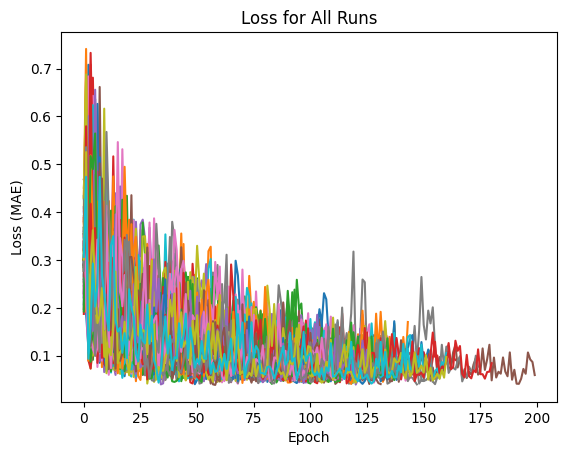

In [ ]:
# Plot the loss for each run
for i, history in enumerate(all_history):
    plt.plot(history['loss'], label=f'Loss (Run {i+1})')

plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Loss for All Runs')
plt.show()


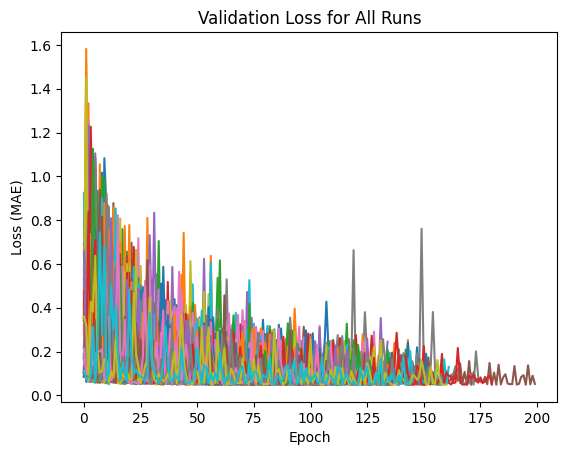

In [ ]:
# Plot the validation loss for each run
for i, history in enumerate(all_history):
    plt.plot(history['val_loss'], label=f'Validation Loss (Run {i+1})')

plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.title('Validation Loss for All Runs')
plt.show()

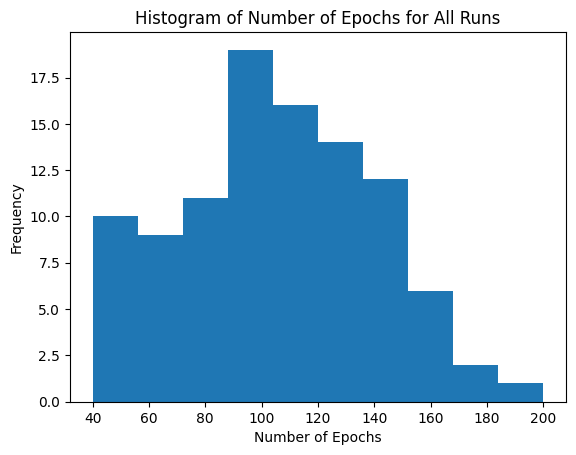

In [ ]:
# prompt: using the all_history list, create a histogram of the number of epochs

epochs_list = []
for history in all_history:
  epochs_list.append(len(history['loss']))

plt.hist(epochs_list, bins=10)  # Adjust bins as needed
plt.xlabel('Number of Epochs')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Epochs for All Runs')
plt.show()


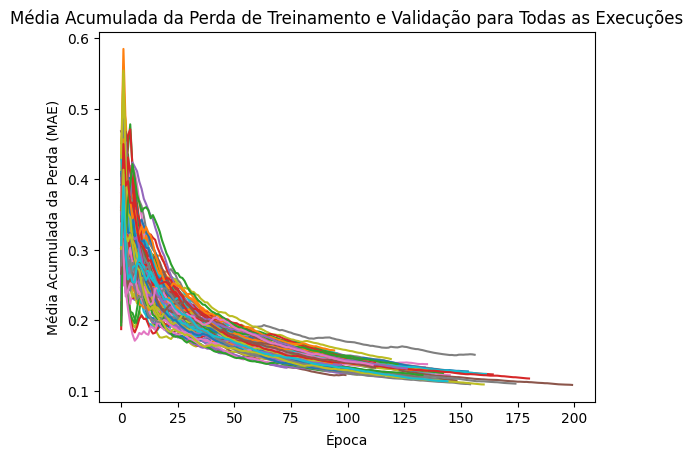

In [ ]:
# prompt: using the all_history list, create a graphic from acumullated mean

accumulated_loss = []

# Itere pelas histórias de cada execução
for history in all_history:
    loss = history['loss']

    # Calcule a média acumulada para cada época
    accumulated_loss.append([sum(loss[:i + 1]) / (i + 1) for i in range(len(loss))])

# Plote as médias acumuladas para todas as execuções
for i, loss in enumerate(accumulated_loss):
    plt.plot(loss, label=f'Média Acumulada da Perda de Validação (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Média Acumulada da Perda (MAE)')
plt.title('Média Acumulada da Perda de Treinamento e Validação para Todas as Execuções')
#plt.legend()
plt.show()

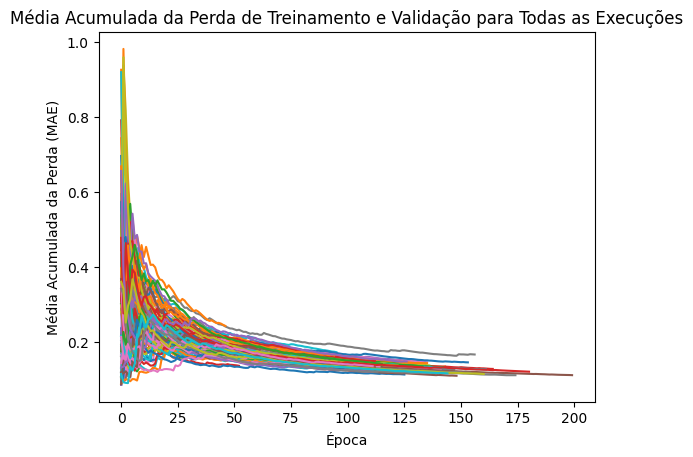

In [ ]:
# Inicialize listas para armazenar as médias acumuladas para loss e val_loss
accumulated_val_loss = []

# Itere pelas histórias de cada execução
for history in all_history:
    val_loss = history['val_loss']

    # Calcule a média acumulada para cada época
    accumulated_val_loss.append([sum(val_loss[:i + 1]) / (i + 1) for i in range(len(val_loss))])

# Plote as médias acumuladas para todas as execuções
for i, val_loss in enumerate(accumulated_val_loss):
    plt.plot(val_loss, label=f'Média Acumulada da Perda de Validação (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Média Acumulada da Perda (MAE)')
plt.title('Média Acumulada da Perda de Treinamento e Validação para Todas as Execuções')
#plt.legend()
plt.show()

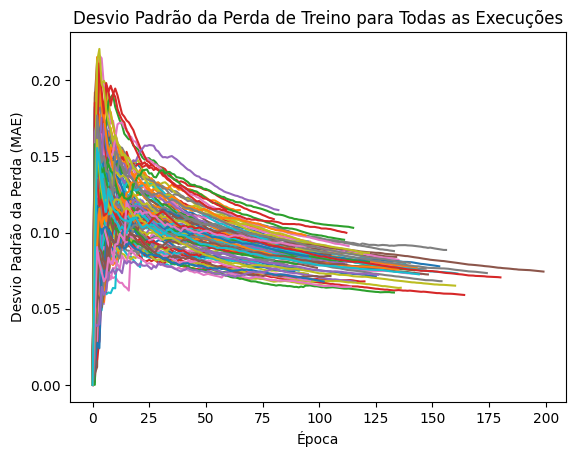

In [ ]:
# Inicialize listas para armazenar os desvios padrão para loss
std_loss = []

# Itere pelas histórias de cada execução
for history in all_history:
    loss = history['loss']

    # Calcule o desvio padrão para cada época
    std_loss.append([np.std(loss[:i + 1]) for i in range(len(loss))])

# Plote os desvios padrão para todas as execuções
for i, loss in enumerate(std_loss):
    plt.plot(loss, label=f'Desvio Padrão da Perda de Treino (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Desvio Padrão da Perda (MAE)')
plt.title('Desvio Padrão da Perda de Treino para Todas as Execuções')
plt.show()

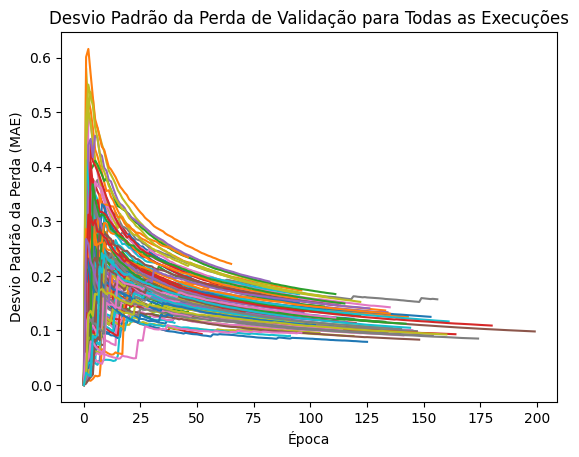

In [ ]:
# Inicializar lista para armazenar os desvios padrão para val_loss
std_val_loss = []

# Iterar pelas histórias de cada execução
for history in all_history:
    val_loss = history['val_loss']

    # Calcule o desvio padrão para cada época
    std_val_loss.append([np.std(val_loss[:i + 1]) for i in range(len(val_loss))])

# Plotar os desvios padrão para todas as execuções
for i, val_loss in enumerate(std_val_loss):
    plt.plot(val_loss, label=f'Desvio Padrão da Perda de Validação (Execução {i + 1})')

plt.xlabel('Época')
plt.ylabel('Desvio Padrão da Perda (MAE)')
plt.title('Desvio Padrão da Perda de Validação para Todas as Execuções')
plt.show()


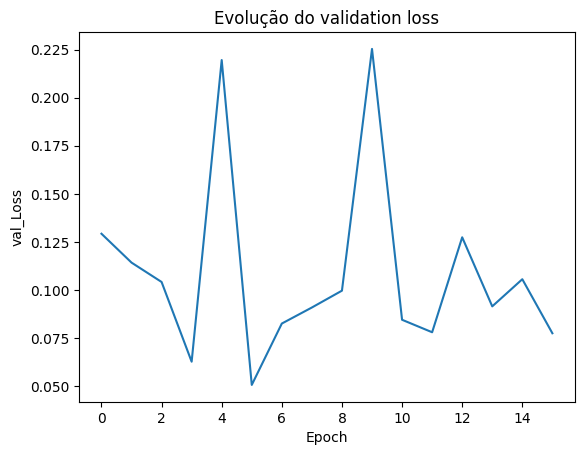

In [ ]:
# Extrair a perda do histórico do melhor modelo
loss = best_history.history['val_loss']

# Plotar o gráfico da perda
plt.plot(loss)
plt.title('Evolução do validation loss')
plt.xlabel('Epoch')
plt.ylabel('val_Loss')

# Caminho para salvar o arquivo
file_path = f'/content/drive/MyDrive/Mestrado/Resultados/GRU/GRU_p{patience}_bestresults/GRU_1a{runs}runs_p{patience}_loss_plot_test.png'

# Criar os diretórios necessários
os.makedirs(os.path.dirname(file_path), exist_ok=True)

plt.savefig(file_path)

plt.show()

In [ ]:
# Converter as listas de métricas e desvios padrão em DataFrame do pandas
metrics_df = pd.DataFrame(all_metrics)

# Adicionar a coluna 'Run' ao DataFrame metrics_df
metrics_df['Run'] = range(0, runs)

# Caminho para salvar o arquivo CSV no Google Drive
file_path = f'/content/drive/MyDrive/Mestrado/Resultados/GRU/GRU_p{patience}_bestresults/GRU_1a{runs}runs_p{patience}_test.csv'

# Salvar o DataFrame metrics_df como um arquivo CSV
metrics_df.to_csv(file_path, index=False)

In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/Mestrado/Resultados/GRU/GRU_p{patience}_bestresults/GRU_1a{runs}runs_p{patience}_test.csv')

# Encontra a linha com o menor valor na coluna MAPE
min_mape_row = df.loc[df['MAPE'].idxmin()]

# Exibe o resultado
print(min_mape_row)

MAE     1.126397e+03
MSE     1.970603e+06
RMSE    1.403782e+03
MAPE    1.009100e+00
R2      9.662175e-01
Run     4.800000e+01
Name: 48, dtype: float64


In [ ]:
# Função para carregar o melhor modelo e suas métricas
def load_model_and_metrics(filename):
    # Carregar o modelo e suas métricas
    model = tf.keras.models.load_model(filename + '.keras')
    metrics = {}
    with open(filename + '.txt', 'r') as f:
        for line in f:
            key, value = line.strip().split(': ')
            if key == 'Seed':
                metrics[key] = int(value)
            else:
                metrics[key] = float(value)

    # Carregar o otimizador
    with open(filename + '_optimizer.pkl', 'rb') as f:
        optimizer_config = pickle.load(f)
    optimizer = tf.keras.optimizers.get({'class_name': optimizer_config['name'], 'config': optimizer_config})

    return model, optimizer, metrics

# Caminho do melhor modelo salvo
results_dir = f'/content/drive/MyDrive/Mestrado/Resultados/GRU/GRU_p{patience}_bestresults'
best_model_path = os.path.join(results_dir, 'best_model')

# Carregar o melhor modelo e suas métricas
best_model, best_optimizer, best_metrics = load_model_and_metrics(best_model_path)

# Fazer previsões usando o melhor modelo
val_predict = best_model.predict(validation_dataset)
predict = (val_predict * train_std) + train_mean

# Ajustar os dados de entrada e previstos para terem o mesmo tamanho
y_real = test_not_norm[lookback:]
y_predict = predict.squeeze()

# Organizar datas

# Plotar os dados reais e as previsões
plt.figure(figsize=(10, 6))
plt.plot(y_real, label='Real')
plt.plot(y_predict, label='Previsão')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Comparação entre os valores reais e as previsões')
plt.legend()

# Ajustar o eixo x para exibir as datas corretamente# Ajustar o eixo x para exibir as datas corretamente
plt.xticks(np.arange(1, len(df_test['Date']), step=50), df_test['Date'][np.arange(df_test.index[0], df_test.index[-1], step=50)], ha='right')


# Caminho para salvar o arquivo
file_path = f'/content/drive/MyDrive/Mestrado/Resultados/GRU/GRU_p{patience}_bestresults/GRU_1a{runs}runs_p{patience}_comparison_plot_test.png'

# Criar os diretórios necessários
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Salvar o gráfico
plt.savefig(file_path)

# Mostrar o gráfico
plt.show()

ValueError: File not found: filepath=/content/drive/MyDrive/Mestrado/Resultados/GRU/GRU_p10_bestresults/best_model.keras. Please ensure the file is an accessible `.keras` zip file.

#Carregar o melhor modelo para ver se o resultado é o mesmo

In [ ]:
def load_model_and_metrics(filename):
    # Carregar o modelo e suas métricas
    model = tf.keras.models.load_model(filename + '.keras')
    metrics = {}
    with open(filename + '.txt', 'r') as f:
        for line in f:
            key, value = line.strip().split(': ')
            if key == 'Seed':
                metrics[key] = int(value)
            else:
                metrics[key] = float(value)

    # Carregar o otimizador
    with open(filename + '_optimizer.pkl', 'rb') as f:
        optimizer_config = pickle.load(f)
    optimizer = tf.keras.optimizers.get({'class_name': optimizer_config['name'], 'config': optimizer_config})

    return model, optimizer, metrics


In [ ]:
# Carrega o melhor modelo e suas métricas
best_model, best_optimizer, best_metrics = load_model_and_metrics(os.path.join(results_dir, 'best_model'))
print("Melhor MAPE:", best_metrics['MAPE'])

# Definir a seed para reproduzir os resultados
seed = best_metrics['Seed']
random.seed(seed)
tf.random.set_seed(seed)


Melhor MAPE: 0.9560857124902419


In [ ]:

# Constrói o modelo GRU com os melhores parâmetros
def build_model(n_layers, n_units_lstm1, dropout_rate_lstm1, activation_lstm1, n_units_dense, activation_dense, lookback):
    model = Sequential()
    model.add(GRU(n_units_lstm1, activation=activation_lstm1, input_shape=(lookback, 1)))
    model.add(Dropout(dropout_rate_lstm1))
    model.add(Dense(n_units_dense, activation=activation_dense))
    model.add(Dense(1))
    return model

# Construir e compilar o modelo
model = build_model(n_layers, n_units_lstm1, dropout_rate_lstm1, activation_lstm1, n_units_dense, activation_dense, lookback)
model.compile(optimizer=best_optimizer, loss='mae')

# Definir os callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Treinar o modelo
history = model.fit(train_dataset, epochs=200, validation_data=validation_dataset, callbacks=[early_stopping], verbose=1)

# Fazer previsões
val_predict = model.predict(validation_dataset)
predict = (val_predict * train_std) + train_mean

# Ajustar os dados de entrada e previstos para terem o mesmo tamanho
y_real = test_not_norm[lookback:]
y_predict = predict.squeeze()

# Calcular métricas
mae = mean_absolute_error(y_real, y_predict)
mse = mean_squared_error(y_real, y_predict)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_real - y_predict) / y_real)) * 100
r2 = r2_score(y_real, y_predict)

# Imprimir as métricas
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}, R2: {r2}")


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.3585 - val_loss: 0.3406
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.6462 - val_loss: 0.0893
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0613 - val_loss: 0.1157
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0666 - val_loss: 0.0703
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1914 - val_loss: 0.0651
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.1535 - val_loss: 0.1187
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1301 - val_loss: 0.0577
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1971 - val_loss: 0.3287
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.4324 - val_loss: 0.0604
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.2184 - val_loss: 0.2300
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1026 - val_loss: 0.0666
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1

# Fim